# Select initial parameters for GALAH DR4 analysis

In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import pandas as pd
from astropy.table import Table, join
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
try:
    from zero_point import zpt
    zpt.load_tables()
except:
    raise ImportError('You need to install the package zero_point from here: https://gitlab.com/icc-ub/public/gaiadr3_zeropoint')
    
# Basic definitions
fancy_labels = dict()
fancy_labels['teff'] = r'$T_\mathrm{eff}~/~\mathrm{K}$'
fancy_labels['logg'] = r'$\log (g~/~\mathrm{cm\,s^{-2}})$'
fancy_labels['vmic'] = r'$v_\mathrm{mic}~/~\mathrm{km\,s^{-1}}$'
fancy_labels['vsini'] = r'$v \sin i~/~\mathrm{km\,s^{-1}}$'
fancy_labels['bp_rp'] = r'$BP-RP~/~\mathrm{mag}$'
fancy_labels['j_ks'] = r'$J-K_S~/~\mathrm{mag}$'
fancy_labels['m_g'] = r'$M_G~/~\mathrm{mag}$'
fancy_labels['m_ks'] = r'$M_{K_S}~/~\mathrm{mag}$'
fancy_labels['fe_h'] = r'$\mathrm{[Fe/H]}$'
fancy_labels['c_fe'] = r'$\mathrm{[C/Fe]}$'
fancy_labels['n_fe'] = r'$\mathrm{[N/Fe]}$'
fancy_labels['o_fe'] = r'$\mathrm{[O/Fe]}$'

## Possible Parameter Sources: GALAH DR4 Reduction, GALAH DR3, Gaia DR3, IRFM+

In [2]:
reduction_download_date = 220714

In [3]:
# https://cloud.datacentral.org.au/apps/files/?dir=/GALAH/obs/reductions/Iraf_6.0
dr60 = Table.read('../observations/dr6.0_'+str(reduction_download_date)+'.fits')
dr60.sort('sobject_id')
unique_sobject_ids, unique_sobject_id_indices = np.unique(dr60['sobject_id'], return_index=True)
dr60 = dr60[unique_sobject_id_indices]
dr60.write('../observations/dr6.0_'+str(reduction_download_date)+'.fits',overwrite=True)

In [4]:
def prepare_gaiadr3_xmatch():
    """
    SELECT
    galah.sobject_id,
    tmass.designation as tmass_id,
    tmass.ph_qual as tmass_ph_qual,
    tmass.ra as raj2000,
    tmass.dec as dej2000,
    tmass.j_m, tmass.j_msigcom,
    tmass.h_m, tmass.h_msigcom,
    tmass.ks_m, tmass.ks_msigcom,
    calj.r_med_geo,calj.r_lo_geo,calj.r_hi_geo,
    calj.r_med_photogeo,calj.r_lo_photogeo,calj.r_hi_photogeo,
    calj.flag as calj_flag,
    gaia.*
    FROM gaiadr3.gaia_source as gaia
    LEFT OUTER JOIN
        external.gaiaedr3_distance as calj
        ON calj.source_id = gaia.source_id
    LEFT OUTER JOIN
        gaiadr3.tmass_psc_xsc_best_neighbour AS tmassxmatch
        ON tmassxmatch.source_id = gaia.source_id
    LEFT OUTER JOIN
        gaiadr3.tmass_psc_xsc_join AS tmass_join
        ON tmass_join.clean_tmass_psc_xsc_oid = tmassxmatch.clean_tmass_psc_xsc_oid
    LEFT OUTER JOIN
        gaiadr1.tmass_original_valid as tmass
        ON tmass.designation = tmass_join.original_psc_source_id
    INNER JOIN
        user_sbuder.dr60_220714_sobject_id_tmass_id as galah
        ON galah.tmass_id = tmass.designation
    """

    # For upload to Gaia archive, only save sobject_id and tmass_id
    dr60_ids = Table()
    dr60_ids['sobject_id'] = np.array(dr60['sobject_id'],dtype=int)
    dr60_ids['tmass_id'] = np.array(dr60['2mass'],dtype=str)
    dr60_ids.write('../observations/dr6.0_'+str(reduction_download_date)+'_sobject_id_tmass_id.fits',overwrite=True)

    # Upload this table to Gaia archive and then perform the following ADQL query based on the uploaded table:
    # Download result as dr60_'+str(reduction_download_date)+'_tmass_gaiadr3_xmatch.fits'
    
prepare_gaiadr3_xmatch()

In [5]:
tmass_gaiadr3 = Table.read('../auxiliary_information/dr60_'+str(reduction_download_date)+'_tmass_gaiadr3_xmatch.fits')

In [6]:
def correct_gband(bp_rp, astrometric_params_solved, phot_g_mean_mag, phot_g_mean_flux):
    """
    Correct the G-band fluxes and magnitudes for the input list of Gaia EDR3 data.
    
    Source: https://github.com/agabrown/gaiaedr3-6p-gband-correction
    
    Parameters
    ----------
    
    bp_rp: float, numpy.ndarray
        The (BP-RP) colour listed in the Gaia EDR3 archive.
    astrometric_params_solved: int, numpy.ndarray
        The astrometric solution type listed in the Gaia EDR3 archive.
    phot_g_mean_mag: float, numpy.ndarray
        The G-band magnitude as listed in the Gaia EDR3 archive.
    phot_g_mean_flux: float, numpy.ndarray
        The G-band flux as listed in the Gaia EDR3 archive.
        
    Returns
    -------
    
    The corrected G-band magnitudes and fluxes. The corrections are only applied to
    sources with a 2-paramater or 6-parameter astrometric solution fainter than G=13, 
    for which a (BP-RP) colour is available.
    
    Example
    -------
    
    gmag_corr, gflux_corr = correct_gband(bp_rp, astrometric_params_solved, phot_g_mean_mag, phot_g_mean_flux)
    """

    if np.isscalar(bp_rp) or np.isscalar(astrometric_params_solved) or np.isscalar(phot_g_mean_mag) \
                    or np.isscalar(phot_g_mean_flux):
        bp_rp = np.float64(bp_rp)
        astrometric_params_solved = np.int64(astrometric_params_solved)
        phot_g_mean_mag = np.float64(phot_g_mean_mag)
        phot_g_mean_flux = np.float64(phot_g_mean_flux)
    
    if not (bp_rp.shape == astrometric_params_solved.shape == phot_g_mean_mag.shape == phot_g_mean_flux.shape):
        raise ValueError('Function parameters must be of the same shape!')
    
    do_not_correct = np.isnan(bp_rp) | (phot_g_mean_mag<13) | (astrometric_params_solved == 31)
    bright_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>=13) & (phot_g_mean_mag<=16)
    faint_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>16)
    bp_rp_c = np.clip(bp_rp, 0.25, 3.0)
    
    correction_factor = np.ones_like(phot_g_mean_mag)
    correction_factor[faint_correct] = 1.00525 - 0.02323*bp_rp_c[faint_correct] + \
        0.01740*np.power(bp_rp_c[faint_correct],2) - 0.00253*np.power(bp_rp_c[faint_correct],3)
    correction_factor[bright_correct] = 1.00876 - 0.02540*bp_rp_c[bright_correct] + \
        0.01747*np.power(bp_rp_c[bright_correct],2) - 0.00277*np.power(bp_rp_c[bright_correct],3)
    
    gmag_corrected = phot_g_mean_mag - 2.5*np.log10(correction_factor)
    gflux_corrected = phot_g_mean_flux * correction_factor
    
    return gmag_corrected, gflux_corrected


In [7]:
# Prepare the photometric information from Gaia eDR3
gmag_corr, gflux_corr = correct_gband(
    bp_rp = tmass_gaiadr3['bp_rp'], 
    astrometric_params_solved = tmass_gaiadr3['astrometric_params_solved'], 
    phot_g_mean_mag = tmass_gaiadr3['phot_g_mean_mag'], 
    phot_g_mean_flux = tmass_gaiadr3['phot_g_mean_flux']
)
tmass_gaiadr3['phot_g_mean_mag'] = gmag_corr
tmass_gaiadr3['phot_g_mean_flux'] = gflux_corr

# Calculation of Gaia eDR3 G/GBP/GRP uncertainties:
# See both https://www.cosmos.esa.int/web/gaia/edr3-passbands
# and https://cdsarc.unistra.fr/viz-bin/ReadMe/I/350?format=html&tex=true#sRM3.63
sigmaG_0 = 0.0027553202
sigmaGBP_0 = 0.0027901700
sigmaGRP_0 = 0.0037793818
tmass_gaiadr3['phot_g_mean_mag_error']   = np.sqrt((-2.5/np.log(10)*tmass_gaiadr3['phot_g_mean_flux_error']/gflux_corr)**2 + sigmaG_0**2)
tmass_gaiadr3['phot_bp_mean_mag_error'] = np.sqrt((-2.5/np.log(10)*tmass_gaiadr3['phot_bp_mean_flux_error']/tmass_gaiadr3['phot_bp_mean_flux'])**2 + sigmaGBP_0**2)
tmass_gaiadr3['phot_rp_mean_mag_error'] = np.sqrt((-2.5/np.log(10)*tmass_gaiadr3['phot_rp_mean_flux_error']/tmass_gaiadr3['phot_rp_mean_flux'])**2 + sigmaGRP_0**2)

# Calculations of Parallax Zeropoint Corrections:
# Following script by Lindegren et al. (2021b)
# https://ui.adsabs.harvard.edu/abs/2021A&A...649A...4L
tmass_gaiadr3['plx_zpt_corr'] = np.zeros(len(tmass_gaiadr3['source_id']))
has_astrometric_params_solved_31_95 = (tmass_gaiadr3['astrometric_params_solved'] == 31) | (tmass_gaiadr3['astrometric_params_solved'] == 95)

# Parallax zeropoint corretion for 
tmass_gaiadr3['plx_zpt_corr'][has_astrometric_params_solved_31_95] = zpt.get_zpt(
    phot_g_mean_mag = tmass_gaiadr3['phot_g_mean_mag'][has_astrometric_params_solved_31_95],
    nu_eff_used_in_astrometry = tmass_gaiadr3['nu_eff_used_in_astrometry'][has_astrometric_params_solved_31_95],
    pseudocolour = tmass_gaiadr3['pseudocolour'][has_astrometric_params_solved_31_95],
    ecl_lat = tmass_gaiadr3['ecl_lat'][has_astrometric_params_solved_31_95],
    astrometric_params_solved = tmass_gaiadr3['astrometric_params_solved'][has_astrometric_params_solved_31_95]
)

tmass_gaiadr3['parallax_raw'] = tmass_gaiadr3['parallax']
tmass_gaiadr3['parallax_error_raw'] = tmass_gaiadr3['parallax_error']
tmass_gaiadr3['parallax'] = tmass_gaiadr3['parallax'] - tmass_gaiadr3['plx_zpt_corr']

/Users/sven/opt/anaconda3/lib/python3.9/site-packages/gaiadr3_zeropoint-0.0.4-py3.9.egg/zero_point/zpt.py:205: UserWarning: The apparent magnitude of one or more of the sources is outside the expected range (6-21 mag). 
                Outside this range, there is no further interpolation, thus the values at 6 or 21 are returned.
  warnings.warn(
/Users/sven/opt/anaconda3/lib/python3.9/site-packages/gaiadr3_zeropoint-0.0.4-py3.9.egg/zero_point/zpt.py:220: UserWarning: The nu_eff_used_in_astrometry of some of the 5p source(s) is outside the expected range (1.1-1.9 
                mag). Outside this range, the zero-point calculated can be seriously wrong.
  warnings.warn(
/Users/sven/opt/anaconda3/lib/python3.9/site-packages/gaiadr3_zeropoint-0.0.4-py3.9.egg/zero_point/zpt.py:233: UserWarning: The pseudocolour of some of the 6p source(s) is outside the expected range (1.24-1.72 mag).
                 The maximum corrections are reached already at 1.24 and 1.72
  warnings.warn(


In [8]:
# There are possibly multiple matches for the same sobject_id. We only take the brightest one in Gaia DR3's Gmag
tmass_gaiadr3.sort(keys='phot_g_mean_mag')
unique_sobject_ids, unique_sobject_id_indices, inverse = np.unique(tmass_gaiadr3['sobject_id'], return_index=True, return_inverse=True)
tmass_gaiadr3 = tmass_gaiadr3[unique_sobject_id_indices]

In [9]:
dr60_crvalcdelt = Table.read('../observations/dr6.0_'+str(reduction_download_date)+'_additional_wavelength_info.fits')

In [10]:
dr60_extra = join(dr60, dr60_crvalcdelt, keys='sobject_id', join_type='left')

In [11]:
dr60_tmass_gaiadr3 = join(dr60_extra, tmass_gaiadr3, keys='sobject_id', join_type='left')
dr60_tmass_gaiadr3['radial_velocity'][dr60_tmass_gaiadr3['radial_velocity'].mask] = np.NaN
dr60_tmass_gaiadr3['radial_velocity_error'][dr60_tmass_gaiadr3['radial_velocity_error'].mask] = np.NaN

inconsistent_rvcom = np.isnan(dr60_tmass_gaiadr3['rv_com']) & np.isfinite(dr60_tmass_gaiadr3['e_rv_com'])
inconsistent_rvcom_closest_to_gaiadr3 = np.argmin(np.array([np.abs(dr60_tmass_gaiadr3['RVCOM_ccd'+str(ccd)][inconsistent_rvcom] - dr60_tmass_gaiadr3['radial_velocity'][inconsistent_rvcom]) for ccd in [1,2,3,4]]),axis=0)
for index, closest in enumerate(inconsistent_rvcom_closest_to_gaiadr3):
    dr60_tmass_gaiadr3['rv_com'][inconsistent_rvcom][index] = dr60_tmass_gaiadr3['RVCOM_ccd'+str(closest+1)][inconsistent_rvcom][index]

dr60_tmass_gaiadr3['diff_rv'] = dr60_tmass_gaiadr3['rv_com'] - dr60_tmass_gaiadr3['radial_velocity']
dr60_tmass_gaiadr3['diff_rv_sigma'] = np.abs(dr60_tmass_gaiadr3['rv_com'] - dr60_tmass_gaiadr3['radial_velocity']) / (np.sqrt(0.167**2 + dr60_tmass_gaiadr3['e_rv_com']**2 + dr60_tmass_gaiadr3['radial_velocity_error']**2))

In [12]:
galah_dr3 = Table.read('../auxiliary_information/GALAH_DR3_main_allspec_v2.fits')
dr60_galah_dr3 = join(dr60, galah_dr3, keys='sobject_id', join_type='left')

In [13]:
def vmic_adjusted(teff, logg):
    """
    Motivated by https://ui.adsabs.harvard.edu/abs/2016A%26A...585A..75D/abstract
    but adjusted by a 0.2 km/s shift to interim vmic from DR4
    """
    return (0.2 + 0.998+3.16*10**(-4)*(teff-5500.)-0.253*(logg-4.0)-2.86*10**(-4)*(teff-5500)*(logg-4.0)+0.165*(logg-4.0)**2.).clip(min=0.5,max=3.0)

In [14]:
def calculate_irfm_teffs(irfm_teff_input):
    """
    From Casagrande et al. (2021) on using Gaia + 2MASS photometry (+logg, [Fe/H] and E(B-V))
    to estimate IRFM Teffs
    """
    
    logg0,feh0,gg0,bp0,rp0,j20,h20,k20,ebv0 = irfm_teff_input

    cpol=np.zeros([12,15])
    cpol[0]  = np.array([7980.8845,  -4138.3457,  1264.9366,   -130.4388,         0.,   285.8393,   -324.2196,   106.8511,    -4.9825,        0.,     4.5138,  -203.7774, 126.6981, -14.7442,    40.7376]) # BP-RP
    cpol[1]  = np.array([8172.2439,  -2508.6436,   442.6771,    -25.3120,         0.,   251.5862,   -240.7094,    86.0579,   -11.2705,        0.,   -45.9166,  -137.4645,  75.3191,  -8.7175,    21.5739]) # BP-J
    cpol[2]  = np.array([8158.9380,  -2146.1221,   368.1630,    -24.4624,         0.,   231.8680,   -170.8788,    52.9164,    -6.8455,        0.,   -45.5554,  -142.9127,  55.2465,  -4.1694,    17.6593]) # BP-H
    cpol[3]  = np.array([8265.6045,  -2124.5574,   355.5051,    -23.1719,         0.,   209.9927,   -161.4505,    50.5904,    -6.3337,        0.,   -27.2653,  -160.3595,  67.9016,  -6.5232,    16.5137]) # BP-K
    cpol[4]  = np.array([9046.6493,  -7392.3789,  2841.5464,          0.,   -85.7060,         0.,    -88.8397,    80.2959,         0.,  -15.3872,         0.,    54.6816,       0.,       0.,   -32.9499]) # RP-J
    cpol[5]  = np.array([8870.9090,  -4702.5469,  1282.3384,          0.,   -15.8164,         0.,    -30.1373,    27.9228,         0.,   -4.8012,         0.,    25.1870,       0.,       0.,   -22.3020]) # RP-H
    cpol[6]  = np.array([8910.6966,  -4305.9927,  1051.8759,          0.,    -8.6045,         0.,    -76.7984,    55.5861,         0.,   -3.9681,         0.,    35.4718,       0.,       0.,   -16.4448]) # RP-K
    cpol[7]  = np.array([8142.3539,  -3003.2988,   499.1325,     -4.8473,         0.,   244.5030,   -303.1783,   125.8628,   -18.2917,        0.,  -125.8444,    59.5183,       0.,       0.,    16.8172]) #  G-J
    cpol[8]  = np.array([8133.8090,  -2573.4998,   554.7657,    -54.0710,         0.,   229.2455,   -206.8658,    68.6489,   -10.5528,        0.,  -124.5804,    41.9630,       0.,       0.,     7.9258]) #  G-H
    cpol[9]  = np.array([8031.7804,  -1815.3523,         0.,     70.7201,    -1.7309,   252.9647,   -342.0817,   161.3031,   -26.7714,        0.,  -120.1133,    42.6723,       0.,       0.,    10.0433]) #  G-K
    cpol[10] = np.array([7346.2000,   5810.6636,         0.,  -2880.3823,   669.3810,   415.3961,   2084.4883,  3509.2200,  1849.0223,        0.,   -49.0748,     6.8032,       0.,       0.,  -100.3419]) # G-BP 
    cpol[11] = np.array([8027.1190,  -5796.4277,         0.,   1747.7036,  -308.7685,   248.1828,   -323.9569,  -120.2658,   225.9584,        0.,   -35.8856,   -16.5715,       0.,       0.,    48.5619]) # G-RP

    # Fitzpatrick/Schlafly extinction coefficients
    itbr = 0.8        
    cRg  = np.array([2.609,-0.475, 0.053])
    cRb  = np.array([2.998,-0.140,-0.175,0.062])
    cRr  = np.array([1.689,-0.059])
    cRj  =  0.719                                         
    cRh  =  0.455
    cRk  =  0.306

    #compute colour dependent extinction coefficients
    bprp0 = (bp0-rp0) - itbr*ebv0
    R_gg  = cRg[0] + cRg[1]*bprp0 + cRg[2]*bprp0*bprp0
    R_bp  = cRb[0] + cRb[1]*bprp0 + cRb[2]*bprp0*bprp0 + cRb[3]*bprp0*bprp0*bprp0
    R_rp  = cRr[0] + cRr[1]*bprp0
    R_j2  = np.zeros(1) + cRj
    R_h2  = np.zeros(1) + cRh
    R_k2  = np.zeros(1) + cRk

    # colour range for dwarfs
    d_r=np.array([2.00,3.00,4.00,4.20,1.05,1.60,1.85,2.10,2.60,2.80,-0.15,0.85])
    d_b=np.array([0.20,0.25,0.40,0.30,0.20,0.20,0.20,0.15,0.25,0.20,-1.00,0.15])

    # colour range for giants
    g_r=np.array([2.55,4.20,4.90,5.30,1.55,2.45,2.70,2.80,3.70,3.90,-0.15,1.15])
    g_b=np.array([0.20,0.90,0.40,0.30,0.60,0.20,0.20,1.00,0.25,0.20,-1.40,0.15])

    clr0       = np.zeros([12,1])
    teff_cal   = np.zeros([12,1])

    clr0[0]  = bp0-rp0 - (R_bp-R_rp)*ebv0
    clr0[1]  = bp0-j20 - (R_bp-R_j2)*ebv0
    clr0[2]  = bp0-h20 - (R_bp-R_h2)*ebv0
    clr0[3]  = bp0-k20 - (R_bp-R_k2)*ebv0
    clr0[4]  = rp0-j20 - (R_rp-R_j2)*ebv0
    clr0[5]  = rp0-h20 - (R_rp-R_h2)*ebv0
    clr0[6]  = rp0-k20 - (R_rp-R_k2)*ebv0
    clr0[7]  = gg0-j20 - (R_gg-R_j2)*ebv0
    clr0[8]  = gg0-h20 - (R_gg-R_h2)*ebv0
    clr0[9]  = gg0-k20 - (R_gg-R_k2)*ebv0
    clr0[10] = gg0-bp0 - (R_gg-R_bp)*ebv0
    clr0[11] = gg0-rp0 - (R_gg-R_rp)*ebv0

    #derive Teff in all colour indices
    for j in range(0,12):
        teff_cal[j] = cpol[j,0] + cpol[j,1]*clr0[j] + cpol[j,2]*clr0[j]*clr0[j] + cpol[j,3]*clr0[j]*clr0[j]*clr0[j] + cpol[j,4]*clr0[j]*clr0[j]*clr0[j]*clr0[j]*clr0[j] + cpol[j,5]*logg0 + cpol[j,6]*logg0*clr0[j] + cpol[j,7]*logg0*clr0[j]*clr0[j] + cpol[j,8]*logg0*clr0[j]*clr0[j]*clr0[j] + cpol[j,9]*logg0*clr0[j]*clr0[j]*clr0[j]*clr0[j]*clr0[j] + cpol[j,10]*feh0 + cpol[j,11]*feh0*clr0[j] + cpol[j,12]*feh0*clr0[j]*clr0[j] + cpol[j,13]*feh0*clr0[j]*clr0[j]*clr0[j] + cpol[j,14]*feh0*logg0*clr0[j]

    return(teff_cal)

# Initial parameter selection

In [15]:
initial_parameters = Table()
initial_parameters['sobject_id'] = dr60['sobject_id']
initial_parameters['tmass_id'] = dr60_tmass_gaiadr3['tmass_id']
initial_parameters['source_id'] = dr60_tmass_gaiadr3['source_id']
for ccd in [1,2,3,4]:
    initial_parameters['snr_c'+str(ccd)+'_iraf'] = dr60['snr'][:,ccd-1]
initial_flags = dict()

# Initialise with NaN values

initial_parameters['sb2_human'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=int)
initial_parameters['sb2_flag'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=int)

for param in ['vrad','teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters[param] = np.NaN
    initial_parameters[param+'_source'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=int)
    initial_flags[param] = [param+r' & -1 & no initial '+param+r' \\']
    
    if param == 'vrad':
        # red
        unmasked_red = ~dr60_tmass_gaiadr3['rv_com'].mask
        initial_parameters[param+'_red'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters[param+'_red'] = np.NaN
        initial_parameters['e_'+param+'_red'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters['e_'+param+'_red'] = np.NaN
        initial_parameters[param+'_red'][unmasked_red] = dr60_tmass_gaiadr3['rv_com'][unmasked_red]
        initial_parameters['e_'+param+'_red'][unmasked_red] = dr60_tmass_gaiadr3['e_rv_com'][unmasked_red]
        # gaia
        unmasked_gaia = ~dr60_tmass_gaiadr3['radial_velocity'].mask
        initial_parameters[param+'_gaia'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters[param+'_gaia'] = np.NaN
        initial_parameters['e_'+param+'_gaia'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters['e_'+param+'_gaia'] = np.NaN
        initial_parameters[param+'_gaia'][unmasked_gaia] = dr60_tmass_gaiadr3['radial_velocity'][unmasked_gaia]
        initial_parameters['e_'+param+'_gaia'][unmasked_gaia] = dr60_tmass_gaiadr3['radial_velocity_error'][unmasked_gaia]
        # galah dr3
        unmasked_dr3 = ~dr60_galah_dr3['rv_galah'].mask
        initial_parameters[param+'_dr3'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters[param+'_dr3'] = np.NaN
        initial_parameters['e_'+param+'_dr3'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters['e_'+param+'_dr3'] = np.NaN
        initial_parameters[param+'_dr3'][unmasked_dr3] = dr60_galah_dr3['rv_galah'][unmasked_dr3]
        initial_parameters['e_'+param+'_dr3'][unmasked_dr3] = dr60_galah_dr3['e_rv_galah'][unmasked_dr3]
        unmasked_dr3 = ~dr60_galah_dr3['rv_guess'].mask
        initial_parameters[param+'_dr3_guess'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters[param+'_dr3'] = np.NaN
        initial_parameters[param+'_dr3_guess'][unmasked_dr3] = dr60_galah_dr3['rv_guess'][unmasked_dr3]

        # flag_sp for galah dr3
        unmasked_dr3 = ~dr60_galah_dr3['flag_sp'].mask
        initial_parameters['flag_sp_dr3'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=int)
        initial_parameters['flag_sp_dr3'][unmasked_dr3] = dr60_galah_dr3['flag_sp'][unmasked_dr3]


    elif param == 'vsini':
        # red
        unmasked_red = ~dr60_tmass_gaiadr3['vbroad_r'].mask
        initial_parameters[param+'_red'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters[param+'_red'] = np.NaN
        initial_parameters[param+'_red'][unmasked_red] = dr60_tmass_gaiadr3['vbroad_r'][unmasked_red]
        # gaia
        unmasked_gaia = ~dr60_tmass_gaiadr3['vbroad'].mask
        initial_parameters[param+'_gaia'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters[param+'_gaia'] = np.NaN
        initial_parameters['e_'+param+'_gaia'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters['e_'+param+'_gaia'] = np.NaN
        initial_parameters[param+'_gaia'][unmasked_gaia] = dr60_tmass_gaiadr3['vbroad'][unmasked_gaia]
        initial_parameters['e_'+param+'_gaia'][unmasked_gaia] = dr60_tmass_gaiadr3['vbroad_error'][unmasked_gaia]
        # galah dr3
        unmasked_dr3 = ~dr60_galah_dr3['vbroad'].mask
        initial_parameters[param+'_dr3'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters[param+'_dr3'] = np.NaN
        initial_parameters['e_'+param+'_dr3'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters['e_'+param+'_dr3'] = np.NaN
        initial_parameters[param+'_dr3'][unmasked_dr3] = dr60_galah_dr3['vbroad'][unmasked_dr3]
        initial_parameters['e_'+param+'_dr3'][unmasked_dr3] = dr60_galah_dr3['e_vbroad'][unmasked_dr3]
    elif param == 'fe_h':
        # red
        unmasked_red = ~dr60_tmass_gaiadr3['fe_h_r'].mask
        initial_parameters[param+'_red'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters[param+'_red'] = np.NaN
        initial_parameters[param+'_red'][unmasked_red] = dr60_tmass_gaiadr3['fe_h_r'][unmasked_red]
        # gaia
        unmasked_gaia = ~dr60_tmass_gaiadr3['mh_gspphot'].mask
        initial_parameters[param+'_gaia'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters[param+'_gaia'] = np.NaN
        initial_parameters['e_'+param+'_gaia'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters['e_'+param+'_gaia'] = np.NaN
        initial_parameters[param+'_gaia'][unmasked_gaia] = dr60_tmass_gaiadr3['mh_gspphot'][unmasked_gaia]
        initial_parameters['e_'+param+'_gaia'][unmasked_gaia] = 0.5*(dr60_tmass_gaiadr3['mh_gspphot_upper'][unmasked_gaia]-dr60_tmass_gaiadr3['mh_gspphot_lower'][unmasked_gaia])
        # galah dr3
        unmasked_dr3 = ~dr60_galah_dr3['fe_h'].mask
        initial_parameters[param+'_dr3'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters[param+'_dr3'] = np.NaN
        initial_parameters['e_'+param+'_dr3'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters['e_'+param+'_dr3'] = np.NaN
        initial_parameters[param+'_dr3'][unmasked_dr3] = dr60_galah_dr3['fe_h'][unmasked_dr3]
        initial_parameters['e_'+param+'_dr3'][unmasked_dr3] = dr60_galah_dr3['e_fe_h'][unmasked_dr3]
    else:
        # red
        unmasked_red = ~dr60_tmass_gaiadr3[param+'_r'].mask
        initial_parameters[param+'_red'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters[param+'_red'] = np.NaN
        initial_parameters[param+'_red'][unmasked_red] = dr60_tmass_gaiadr3[param+'_r'][unmasked_red]
        # gaia
        if param not in ['vmic']:
            unmasked_gaia = ~dr60_tmass_gaiadr3[param+'_gspphot'].mask
            initial_parameters[param+'_gaia'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters[param+'_gaia'] = np.NaN
            initial_parameters['e_'+param+'_gaia'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters['e_'+param+'_gaia'] = np.NaN
            initial_parameters[param+'_gaia'][unmasked_gaia] = dr60_tmass_gaiadr3[param+'_gspphot'][unmasked_gaia]
            initial_parameters['e_'+param+'_gaia'][unmasked_gaia] = 0.5*(dr60_tmass_gaiadr3[param+'_gspphot_upper'][unmasked_gaia]-dr60_tmass_gaiadr3[param+'_gspphot_lower'][unmasked_gaia])
        # galah dr3
        if param == 'vmic':
            initial_parameters['vmic_gaia'] = vmic_adjusted(initial_parameters['teff_gaia'],initial_parameters['logg_gaia'])
        initial_parameters[param+'_dr3'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters[param+'_dr3'] = np.NaN
        initial_parameters[param+'_dr3'][unmasked_dr3] = dr60_galah_dr3[param][unmasked_dr3]
        if param not in ['vmic']:
            initial_parameters['e_'+param+'_dr3'] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters['e_'+param+'_dr3'] = np.NaN
            initial_parameters['e_'+param+'_dr3'][unmasked_dr3] = dr60_galah_dr3['e_'+param][unmasked_dr3]
            
for param in ['bp_rp','parallax','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','j_m','h_m','ks_m']:
    unmasked = ~dr60_tmass_gaiadr3[param].mask
    initial_parameters[param] = -np.ones(len(dr60_tmass_gaiadr3['sobject_id']),dtype=np.float32); initial_parameters[param] = np.NaN
    if param == 'parallax':
        initial_parameters[param][unmasked] = dr60_tmass_gaiadr3[param][unmasked].clip(min=0.001)
    else:
        initial_parameters[param][unmasked] = dr60_tmass_gaiadr3[param][unmasked]

initial_parameters['ebv'] = dr60_tmass_gaiadr3['e_b-v']

vrad_red_and_gaia = (
    np.isfinite(initial_parameters['vrad_red']) &
    np.isfinite(initial_parameters['vrad_gaia'])
)
median_vrad_offset = np.percentile(
    (initial_parameters['vrad_red'][vrad_red_and_gaia] - initial_parameters['vrad_gaia'][vrad_red_and_gaia]),
    q = 50
)
print('Median RV offset between vrad_red and vrad_gaia: '+"{:.3f}".format(median_vrad_offset)+' km/s')

Median RV offset between vrad_red and vrad_gaia: 0.168 km/s


In [16]:
# Use dr60 RV
use_vrad_red = (
    np.isfinite(initial_parameters['vrad_red'])
)
initial_parameters['vrad'][use_vrad_red] = initial_parameters['vrad_red'][use_vrad_red]
initial_parameters['vrad_source'][use_vrad_red] = 0
initial_flags['vrad'].append(r'& 0 & dr60 rv_com \\')

# Use Gaia RV
# Case 1: Gaia available, but no dr60 RV
use_vrad_gaia_case1 = (
    np.isnan(initial_parameters['vrad_red']) &
    np.isfinite(initial_parameters['vrad_gaia'])
)
initial_parameters['vrad'][use_vrad_gaia_case1] = initial_parameters['vrad_gaia'][use_vrad_gaia_case1]
initial_parameters['vrad_source'][use_vrad_gaia_case1] = 1
initial_flags['vrad'].append(r'& 1 & Gaia DR3 radial_velocity, because no rv_com available \\')
# Case 2: Gaia more reliable than dr60 RV
use_vrad_gaia_case2 = (
    np.isfinite(initial_parameters['vrad_red']) &
    np.isfinite(initial_parameters['vrad_gaia']) &
    (initial_parameters['e_vrad_red'] > initial_parameters['e_vrad_gaia'])
)
initial_parameters['vrad'][use_vrad_gaia_case2] = initial_parameters['vrad_gaia'][use_vrad_gaia_case2]
initial_parameters['vrad_source'][use_vrad_gaia_case2] = 1
initial_flags['vrad'].append(r'& 2 & Gaia DR3 radial_velocity more reliable than rv_com \\')

# Use GALAH DR3 RV
# Case 1: DR3 available, but no dr60 RV or Gaia RV
use_vrad_dr3_case1 = (
    np.isnan(initial_parameters['vrad_red']) &
    np.isnan(initial_parameters['vrad_gaia']) &
    np.isfinite(initial_parameters['vrad_dr3'])
)
initial_parameters['vrad'][use_vrad_dr3_case1] = initial_parameters['vrad_dr3'][use_vrad_dr3_case1]
initial_parameters['vrad_source'][use_vrad_dr3_case1] = 4
initial_flags['vrad'].append(r'& 4 & GALAH DR3 radial_velocity, because no initial dr60 or Gaia available \\')
# Case 2: DR3 most precise
use_vrad_dr3_case2 = (
    np.isfinite(initial_parameters['vrad_red']) &
    np.isfinite(initial_parameters['vrad_gaia']) &
    np.isfinite(initial_parameters['vrad_dr3']) &
    (initial_parameters['e_vrad_red'] > initial_parameters['e_vrad_dr3']) &
    (initial_parameters['e_vrad_gaia'] > initial_parameters['e_vrad_dr3'])
)
initial_parameters['vrad'][use_vrad_dr3_case2] = initial_parameters['vrad_dr3'][use_vrad_dr3_case2]
initial_parameters['vrad_source'][use_vrad_dr3_case2] = 8
initial_flags['vrad'].append(r'& 8 & GALAH DR3 radial_velocity, because more reliable than rv_com and Gaia \\')

# Impossible Stellar Parameters for Reduction Pipeline, RV not reliable
unreliable_parameters_for_dr60_rv = (
    np.isfinite(initial_parameters['vrad_red']) &
    (
        (
            np.isnan(initial_parameters['teff_red']) |
            (
                np.isfinite(initial_parameters['teff_red']) &
                (
                    (initial_parameters['teff_red'] < 3000) |
                    (initial_parameters['teff_red'] > 8000)
                )
            )
        ) |
        (
            np.isnan(initial_parameters['logg_red']) |
            (
                np.isfinite(initial_parameters['logg_red']) &
                (
                    (initial_parameters['logg_red'] < -1) |
                    (initial_parameters['logg_red'] > 5.5)
                )
            )
        ) |
        (
            np.isnan(initial_parameters['fe_h_red']) |
            (
                np.isfinite(initial_parameters['fe_h_red']) &
                (
                    (initial_parameters['fe_h_red'] < -4) |
                    (initial_parameters['fe_h_red'] > 1)
                )
            )
        ) |
        (
            np.isnan(initial_parameters['vmic_red']) |
            (
                np.isfinite(initial_parameters['vmic_red']) &
                (
                    (initial_parameters['vmic_red'] < 0) |
                    (initial_parameters['vmic_red'] > 4)
                )
            )
        ) |
        (
            np.isnan(initial_parameters['vsini_red']) |
            (
                np.isfinite(initial_parameters['vsini_red']) &
                (
                    (initial_parameters['vsini_red'] < 0) |
                    (initial_parameters['vsini_red'] > 50)
                )
            )
        )
    )
)
# Case 1: dr60 RV unreliable, and Gaia only source or better source
unreliable_parameters_for_rv_and_gaia_better = (
    unreliable_parameters_for_dr60_rv & 
    (
        (
            np.isfinite(initial_parameters['vrad_gaia']) & 
            np.isnan(initial_parameters['vrad_dr3']) 
        ) |
        (
            np.isfinite(initial_parameters['vrad_gaia']) & 
            np.isfinite(initial_parameters['vrad_dr3']) &
            (initial_parameters['e_vrad_gaia'] < initial_parameters['e_vrad_dr3'])
        )
    )
)
initial_parameters['vrad'][unreliable_parameters_for_rv_and_gaia_better] = initial_parameters['vrad_gaia'][unreliable_parameters_for_rv_and_gaia_better]
initial_parameters['vrad_source'][unreliable_parameters_for_rv_and_gaia_better] = 16
initial_flags['vrad'].append(r'& 16 & rv_com based on unreliable PARAM, using Gaia \\')

# Case 2: dr60 RV unreliable, and DR3 RV only source or better source
unreliable_parameters_for_rv_and_dr3_better = (
    unreliable_parameters_for_dr60_rv & 
    (
        (
            np.isfinite(initial_parameters['vrad_dr3']) & 
            np.isnan(initial_parameters['vrad_gaia']) 
        ) |
        (
            np.isfinite(initial_parameters['vrad_dr3']) & 
            np.isfinite(initial_parameters['vrad_gaia']) &
            (initial_parameters['e_vrad_dr3'] < initial_parameters['e_vrad_gaia'])
        )
    )
)
initial_parameters['vrad'][unreliable_parameters_for_rv_and_dr3_better] = initial_parameters['vrad_dr3'][unreliable_parameters_for_rv_and_dr3_better]
initial_parameters['vrad_source'][unreliable_parameters_for_rv_and_dr3_better] = 32
initial_flags['vrad'].append(r'& 32 & rv_com based on unreliable PARAM, using GALAH DR3 \\')

rv_above_100_and_not_similar_to_gaia = (
    (initial_parameters['vrad_source'] == 0) &
    (np.abs(initial_parameters['vrad']) > 100) &
    (
        # Outside of Gaia Range, when no DR3 available
        np.isfinite(initial_parameters['vrad_gaia']) &
        (
            np.isnan(initial_parameters['vrad_dr3']) &
            (initial_parameters['e_vrad_gaia'] < 10) &
            (np.abs((initial_parameters['vrad_red'] - initial_parameters['vrad_gaia']) / initial_parameters['vrad_gaia']) > 0.1) &
            (np.abs(initial_parameters['vrad_red'] - initial_parameters['vrad_gaia']) > 3 *np.sqrt(median_vrad_offset**2 + initial_parameters['e_vrad_red']**2 + initial_parameters['e_vrad_gaia']**2))
        )
    )
)
initial_parameters['vrad'][rv_above_100_and_not_similar_to_gaia] = initial_parameters['vrad_gaia'][rv_above_100_and_not_similar_to_gaia]
initial_parameters['vrad_source'][rv_above_100_and_not_similar_to_gaia] = 64
initial_flags['vrad'].append(r'& 64 & rv_com above 100 km/s, Gaia more reliable \\')


rv_above_100_and_not_similar_to_dr3 = ((
    (initial_parameters['vrad_source'] == 0) &
    (np.abs(initial_parameters['vrad']) > 100) &
    (
        # Outside of DR3 Range, when no Gaia available
        np.isfinite(initial_parameters['vrad_dr3']) &
        (
            np.isnan(initial_parameters['vrad_gaia']) &
            (initial_parameters['e_vrad_dr3'] < 10) &
            (np.abs((initial_parameters['vrad_red'] - initial_parameters['vrad_dr3']) / initial_parameters['vrad_dr3']) > 0.1) &
            (np.abs(initial_parameters['vrad_red'] - initial_parameters['vrad_dr3']) > 3 *np.sqrt(initial_parameters['e_vrad_red']**2 + initial_parameters['e_vrad_dr3']**2))
        )
    )
) |
(
    (initial_parameters['vrad_source'] == 0) &
    (np.abs(initial_parameters['vrad']) > 100) &
    np.isfinite(initial_parameters['vrad_gaia']) &
    np.isfinite(initial_parameters['vrad_dr3']) &
    (np.abs((initial_parameters['vrad_red'] - initial_parameters['vrad_gaia']) / initial_parameters['vrad_gaia']) > 0.1) &
    (np.abs((initial_parameters['vrad_red'] - initial_parameters['vrad_dr3']) / initial_parameters['vrad_dr3']) > 0.1)
))
initial_parameters['vrad'][rv_above_100_and_not_similar_to_dr3] = initial_parameters['vrad_dr3'][rv_above_100_and_not_similar_to_dr3]
initial_parameters['vrad_source'][rv_above_100_and_not_similar_to_dr3] = 128
initial_flags['vrad'].append(r'& 128 & rv_com above 100 km/s, DR3 more reliable \\')

has_dr3_rv_guess = (
    np.isnan(initial_parameters['vrad']) & 
    np.isfinite(initial_parameters['vrad_dr3_guess'])
)
initial_parameters['vrad'][has_dr3_rv_guess] = initial_parameters['vrad_dr3_guess'][has_dr3_rv_guess]
initial_parameters['vrad_source'][has_dr3_rv_guess] = 256
initial_flags['vrad'].append(r'& 256 & rv_guess from DR3 available \\')

initial_parameters['vrad'][np.isnan(initial_parameters['vrad'])] = 0.0

In [17]:
initial_parameters['crval_flag'] = np.zeros(len(dr60_tmass_gaiadr3['sobject_id']),dtype=int)
initial_parameters['cdelt_flag'] = np.zeros(len(dr60_tmass_gaiadr3['sobject_id']),dtype=int)

ranges = dict()

for ccd in [1,2,3,4]:
    for cindex, key in enumerate(['CRVAL1','CDELT1']):
        
        if key == 'CRVAL1':
            if ccd == 1:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 4711.5
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 4715.5
            if ccd == 2:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 5646.7
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 5650.7
            if ccd == 3:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 6475.8
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 6480.5
            if ccd == 4:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 7583.5
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 7587.5
        if key == 'CDELT1':
            if ccd == 1:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 0.04591
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 0.04605
            if ccd == 2:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 0.0545
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 0.0548
            if ccd == 3:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 0.06303
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 0.063215
            if ccd == 4:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 0.07342
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 0.07367
                
for ccd in [1,2,3,4]:
    outside_of_crval_range = (
        (dr60_tmass_gaiadr3['CRVAL1_ccd'+str(ccd)] < ranges['CRVAL1_ccd'+str(ccd)+'_p1']) |
        (dr60_tmass_gaiadr3['CRVAL1_ccd'+str(ccd)] > ranges['CRVAL1_ccd'+str(ccd)+'_p99'])
    )
    initial_parameters['crval_flag'][outside_of_crval_range] += 2**(ccd-1)
    outside_of_cdelt_range = (
        (dr60_tmass_gaiadr3['CDELT1_ccd'+str(ccd)] < ranges['CDELT1_ccd'+str(ccd)+'_p1']) |
        (dr60_tmass_gaiadr3['CDELT1_ccd'+str(ccd)] > ranges['CDELT1_ccd'+str(ccd)+'_p99'])
    )    
    initial_parameters['cdelt_flag'][outside_of_cdelt_range] += 2**(ccd-1)   

In [18]:
for param in ['reduction_flags','pivot','plate','res']:
    initial_parameters[param] = dr60_tmass_gaiadr3[param]

In [19]:
# Binary List
for sobject_id in [
    131216001101015,
    131216001101026,
    131216001101059,
    131216001101122, # Triple!
    131216001101236,
    131216001601054,
    131216002101139,
    131217003901101,
    140316004601011,
    140409003001336,
    140707000601023,
    140809004901383,
    140810004201274,
    140814003801018,
    140814004801381,
    141231004001024,
    150429003101026,
    150703004101373,
    161213002601110,
    170220004101078,
    190614005601293,
    200214003001072,
    200907005101005,
    200926003601272,
    210325001601082,
]:
    match = np.where(initial_parameters['sobject_id'] == sobject_id)[0]
    if len(match) > 0:
        match = match[0]
        initial_parameters['sb2_human'][match] = 0
        
# Non-Binary List
for sobject_id in [
    131216001101030,
    131216001101137,
    131216001101160,
    131216001101182,
    131216001101212,
    131216001601028,
    140112002301280,
    140711000601301,
    140807003101174,
    150603003801283,
    150901003001265,
    161013004901145,
    170907004601209,
    171228001601255,
    191107003601120,
    200903001601114,
    200907004101286,
    210403003201202,
    210405003101321,
    210523002601013,
    210524002701198,
    210921002801230,
    220217003301219,
    220422002101278,
    220420002601108,
    220420004101377,
]:
    match = np.where(initial_parameters['sobject_id'] == sobject_id)[0]
    if len(match) > 0:
        match = match[0]
        initial_parameters['sb2_human'][match] = 1
        
# Hot and/or Fast-Rot, binarity unclear
for sobject_id in [
    131216001601032,
    131216001601042,
    131216001601323,
    131216001601338,
    140111002101195,
    140409003001151,
    150427001301353,
    161213002101257,
    161228002501361,
    171227003601015,
    180130002801368,
    190224001601057,
    201006001601153,
    210328002101234,
    210515003301055,
]:
    match = np.where(initial_parameters['sobject_id'] == sobject_id)[0]
    if len(match) > 0:
        match = match[0]
        initial_parameters['sb2_human'][match] = 2

# GALAH RV wrong
for sobject_id in [
    131216002101190,
    140112001801107,
    140112001801392,
    140115003101246,
    140115003101336,
    140710004601359,
    140813001601077,
    141202003701020,
    150112003001210,
    150901003001265,
    170127002301226,
    170806002601012,
    190224004201399,
    220124001601273,
    220218002101314,
]:
    match = np.where(initial_parameters['sobject_id'] == sobject_id)[0]
    if len(match) > 0:
        match = match[0]
        initial_parameters['sb2_human'][match] = 4
        
# GALAH spectrum bad
for sobject_id in [
    140310003801343,
    140713001901346,
    140810004201377,
    150109001001044,
    150109001001349,
    150410002801242,    
    150607004101040,
    170509003701359,
    200512002101170,
    200513002601132,
    200514005201245,
    200517003201391,
    200714001301029,
    200714001301058,
    200803003201037,
    210403002101190,
    210925002101043,
    220422002101291,
]:
    match = np.where(initial_parameters['sobject_id'] == sobject_id)[0]
    if len(match) > 0:
        match = match[0]
        initial_parameters['sb2_human'][match] = 8


In [20]:
for param in ['teff','logg','fe_h','vmic','vsini']:
    
    finite_dr60_values = np.isfinite(initial_parameters[param+'_red'])
    initial_parameters[param][finite_dr60_values] = initial_parameters[param+'_red'][finite_dr60_values]
    initial_parameters[param+'_source'][finite_dr60_values] = 0
    initial_flags[param].append(r'& 0 & dr60 value \\')
    
    # if DR3 available, and flag_sp < 63: use it
    finite_dr3_values = np.isfinite(initial_parameters[param+'_dr3']) & (initial_parameters['flag_sp_dr3'] < 64)
    initial_parameters[param][finite_dr3_values] = initial_parameters[param+'_dr3'][finite_dr3_values]
    initial_parameters[param+'_source'][finite_dr3_values] = 1
    initial_flags[param].append(r'& 1 & DR3 value \\')
    
    # if not parameters available yet, use Gaia if available
    finite_gaia_values = np.isnan(initial_parameters[param]) & np.isfinite(initial_parameters[param+'_gaia'])
    initial_parameters[param][finite_gaia_values] = initial_parameters[param+'_gaia'][finite_gaia_values]
    initial_parameters[param+'_source'][finite_gaia_values] = 2
    initial_flags[param].append(r'& 2 & Gaia GSPPhot Value \\')
    
    # If none of the above are available, use the DR3 values that are flagged as really bad.
    finite_dr3_values = np.isnan(initial_parameters[param]) & np.isfinite(initial_parameters[param+'_dr3'])
    initial_parameters[param][finite_dr3_values] = initial_parameters[param+'_dr3'][finite_dr3_values]
    initial_parameters[param+'_source'][finite_dr3_values] = 4
    initial_flags[param].append(r'& 4 & DR3 value (but flagged) \\')
    
    initial_flags[param].append(r'& 8 & Adjusted by hand \\')

In [21]:
# Readjustment of initial parameters for cool dwarfs < 5000K according to Gaia
red_dwarfs_below_5000K_according_to_gaia_bp_rp = (
    (
        (initial_parameters['teff_gaia'] < 5000) &
        (initial_parameters['logg_gaia'] > 4.0)
    ) |
    (
        np.isfinite(initial_parameters['teff_gaia']) &
        (initial_parameters['bp_rp'] > 1) &(initial_parameters['bp_rp'] > 1) &
        (initial_parameters['phot_g_mean_mag'] + 5*np.log10(initial_parameters['parallax']/100) > 5.0)
    )
)
initial_parameters['teff'][red_dwarfs_below_5000K_according_to_gaia_bp_rp] = initial_parameters['teff_gaia'][red_dwarfs_below_5000K_according_to_gaia_bp_rp]
initial_parameters['logg'][red_dwarfs_below_5000K_according_to_gaia_bp_rp] = initial_parameters['logg_gaia'][red_dwarfs_below_5000K_according_to_gaia_bp_rp]
initial_parameters['fe_h'][red_dwarfs_below_5000K_according_to_gaia_bp_rp] = initial_parameters['fe_h_gaia'][red_dwarfs_below_5000K_according_to_gaia_bp_rp].clip(min=-0.5,max=0.5)
initial_parameters['vmic'][red_dwarfs_below_5000K_according_to_gaia_bp_rp] = initial_parameters['vmic_gaia'][red_dwarfs_below_5000K_according_to_gaia_bp_rp]
initial_parameters['vsini'][red_dwarfs_below_5000K_according_to_gaia_bp_rp] = initial_parameters['vsini_gaia'][red_dwarfs_below_5000K_according_to_gaia_bp_rp]
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][red_dwarfs_below_5000K_according_to_gaia_bp_rp] = 2

In [22]:
# Readjustment of initial parameters for cool giants < 4000K according to Gaia
giants_below_4000k_according_to_gaia = (
    (initial_parameters['teff_gaia'] < 4000) &
    (initial_parameters['logg_gaia'] < 2.0)
)
initial_parameters['teff'][giants_below_4000k_according_to_gaia] = initial_parameters['teff_gaia'][giants_below_4000k_according_to_gaia]
initial_parameters['logg'][giants_below_4000k_according_to_gaia] = initial_parameters['logg_gaia'][giants_below_4000k_according_to_gaia]
initial_parameters['fe_h'][giants_below_4000k_according_to_gaia] = initial_parameters['fe_h_gaia'][giants_below_4000k_according_to_gaia].clip(min=-0.5,max=0.5)
initial_parameters['vmic'][giants_below_4000k_according_to_gaia] = initial_parameters['vmic_gaia'][giants_below_4000k_according_to_gaia]
initial_parameters['vsini'][giants_below_4000k_according_to_gaia] = initial_parameters['vsini_gaia'][giants_below_4000k_according_to_gaia]
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][giants_below_4000k_according_to_gaia] = 2

In [23]:
# Readjustment of initial parameters for cool giants < 4000K according to Gaia or 
cool_dwarfs_gaia = (
    (initial_parameters['teff_source'] == 0) &
    (np.isfinite(initial_parameters['logg_gaia'])) &
    (initial_parameters['j_m'] - initial_parameters['ks_m'] > 0.5) &
    (initial_parameters['ks_m'] + 5*np.log10(initial_parameters['parallax']/100) > 3.0)
)
initial_parameters['teff'][cool_dwarfs_gaia] = initial_parameters['teff_gaia'][cool_dwarfs_gaia]
initial_parameters['logg'][cool_dwarfs_gaia] = initial_parameters['logg_gaia'][cool_dwarfs_gaia]
initial_parameters['fe_h'][cool_dwarfs_gaia] = initial_parameters['fe_h_gaia'][cool_dwarfs_gaia].clip(min=-0.5,max=0.5)
initial_parameters['vmic'][cool_dwarfs_gaia] = initial_parameters['vmic_gaia'][cool_dwarfs_gaia]
initial_parameters['vsini'][cool_dwarfs_gaia] = initial_parameters['vsini_gaia'][cool_dwarfs_gaia]
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][cool_dwarfs_gaia] = 2

cool_dwarfs_dr3 = (
    (initial_parameters['teff_source'] == 0) &
    (np.isnan(initial_parameters['logg_gaia'])) &
    (np.isfinite(initial_parameters['logg_dr3'])) &
    (initial_parameters['j_m'] - initial_parameters['ks_m'] > 0.5) &
    (initial_parameters['ks_m'] + 5*np.log10(initial_parameters['parallax']/100) > 3.0)
)
initial_parameters['teff'][cool_dwarfs_dr3] = initial_parameters['teff_dr3'][cool_dwarfs_dr3]
initial_parameters['logg'][cool_dwarfs_dr3] = initial_parameters['logg_dr3'][cool_dwarfs_dr3]
initial_parameters['fe_h'][cool_dwarfs_dr3] = initial_parameters['fe_h_dr3'][cool_dwarfs_dr3].clip(min=-0.5,max=0.5)
initial_parameters['vmic'][cool_dwarfs_dr3] = initial_parameters['vmic_dr3'][cool_dwarfs_dr3]
initial_parameters['vsini'][cool_dwarfs_dr3] = initial_parameters['vsini_dr3'][cool_dwarfs_dr3]
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][cool_dwarfs_dr3] = 4
    
cool_dwarfs_without_gaia_dr3 = (
    (initial_parameters['teff_source'] == 0) &
    (np.isnan(initial_parameters['logg_gaia'])) &
    (np.isnan(initial_parameters['logg_dr3'])) &
    (initial_parameters['j_m'] - initial_parameters['ks_m'] > 0.5) &
    (initial_parameters['ks_m'] + 5*np.log10(initial_parameters['parallax']/100) > 3.0)
)
initial_parameters['teff'][cool_dwarfs_without_gaia_dr3] = 6250 - 1000 * initial_parameters['bp_rp'][cool_dwarfs_without_gaia_dr3] - 20 * initial_parameters['bp_rp'][cool_dwarfs_without_gaia_dr3]**2
initial_parameters['logg'][cool_dwarfs_without_gaia_dr3] = 4.4 + 0.07*(initial_parameters['phot_g_mean_mag'][cool_dwarfs_without_gaia_dr3] + 5*np.log10(initial_parameters['parallax'][cool_dwarfs_without_gaia_dr3]/100) - 5)
initial_parameters['fe_h'][cool_dwarfs_without_gaia_dr3] = -0.1
initial_parameters['vmic'][cool_dwarfs_without_gaia_dr3] = vmic_adjusted(initial_parameters['teff'][cool_dwarfs_without_gaia_dr3],initial_parameters['logg'][cool_dwarfs_without_gaia_dr3]).clip(min =  0.5, max=2.0)
initial_parameters['vsini'][cool_dwarfs_without_gaia_dr3] = 5.0
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][cool_dwarfs_without_gaia_dr3] = 8

In [24]:
cool_giantsaccording_to_cmd = (
    (initial_parameters['teff_source'] == 0) &
    (initial_parameters['bp_rp'] > 2) &
    (initial_parameters['ks_m'] + 5*np.log10(initial_parameters['parallax']/100) < -3.0) &
    (initial_parameters['phot_g_mean_mag'] + 5*np.log10(initial_parameters['parallax']/100) > -3.5)
)
initial_parameters['teff'][cool_giantsaccording_to_cmd] = 4400 - (4400-3200)/0.65 * (initial_parameters['j_m'][cool_giantsaccording_to_cmd] - initial_parameters['ks_m'][cool_giantsaccording_to_cmd] - 0.51*(initial_parameters['ebv'][cool_giantsaccording_to_cmd]).clip(min=0.0, max=0.5) - 0.7)
initial_parameters['logg'][cool_giantsaccording_to_cmd] = 2.25 + (initial_parameters['ks_m'][cool_giantsaccording_to_cmd] + 5*np.log10(initial_parameters['parallax'][cool_giantsaccording_to_cmd]/100) +1.5) * 2.25/6.0
initial_parameters['fe_h'][cool_giantsaccording_to_cmd] = initial_parameters['fe_h'][cool_giantsaccording_to_cmd].clip(min=-0.25,max=0.25)
initial_parameters['vmic'][cool_giantsaccording_to_cmd] = vmic_adjusted(initial_parameters['teff'][cool_giantsaccording_to_cmd],initial_parameters['logg'][cool_giantsaccording_to_cmd]).clip(min =  0.5, max=2.0)
initial_parameters['vsini'][cool_giantsaccording_to_cmd] = 5.0
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][cool_giantsaccording_to_cmd] = 8

In [25]:
warm_loggbelow3p4_gaia_mk_above_0 = (
    np.isfinite(initial_parameters['logg_gaia']) &
    (initial_parameters['logg'] < 3.4) & 
    (initial_parameters['logg'] < 4.25 - (6200 - initial_parameters['teff'])/475) &
    ~(initial_parameters['ks_m'] + 5*np.log10(initial_parameters['parallax']/100.) < 0)
)
initial_parameters['teff'][warm_loggbelow3p4_gaia_mk_above_0] = initial_parameters['teff_gaia'][warm_loggbelow3p4_gaia_mk_above_0]
initial_parameters['logg'][warm_loggbelow3p4_gaia_mk_above_0] = initial_parameters['logg_gaia'][warm_loggbelow3p4_gaia_mk_above_0]
initial_parameters['fe_h'][warm_loggbelow3p4_gaia_mk_above_0] = -0.25
initial_parameters['vmic'][warm_loggbelow3p4_gaia_mk_above_0] = vmic_adjusted(initial_parameters['teff'][warm_loggbelow3p4_gaia_mk_above_0],initial_parameters['logg'][warm_loggbelow3p4_gaia_mk_above_0]).clip(min =  0.5, max=2.0)
initial_parameters['vsini'][warm_loggbelow3p4_gaia_mk_above_0] = 5.0
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][warm_loggbelow3p4_gaia_mk_above_0] = 4

In [26]:
# Readjustment of initial parameters att Teff and logg edges, where Gaia is available
outliers_teff_logg = (
    (
        (initial_parameters['teff'] <= 3100) &
        (initial_parameters['teff_gaia'] > 3500)
    ) |
    (
        (initial_parameters['teff'] >= 7950) &
        np.isfinite(initial_parameters['teff_gaia'])
    ) |
    (
        (initial_parameters['logg'] <= 0) &
        np.isfinite(initial_parameters['logg_gaia'])
    ) |
    (
        (initial_parameters['logg'] >= 5) &
        np.isfinite(initial_parameters['logg_gaia'])
    )
)
initial_parameters['teff'][outliers_teff_logg] = initial_parameters['teff_gaia'][outliers_teff_logg]
initial_parameters['logg'][outliers_teff_logg] = initial_parameters['logg_gaia'][outliers_teff_logg]
initial_parameters['fe_h'][outliers_teff_logg] = initial_parameters['fe_h_gaia'][outliers_teff_logg].clip(min=-0.5,max=0.5)
initial_parameters['vmic'][outliers_teff_logg] = initial_parameters['vmic_gaia'][outliers_teff_logg]
initial_parameters['vsini'][outliers_teff_logg] = initial_parameters['vsini_gaia'][outliers_teff_logg]
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][outliers_teff_logg] = 2

In [27]:
# logg < 0
logg_0 = (initial_parameters['logg'] < 0)
initial_parameters['teff'][logg_0] = (7000 - 2900 * (initial_parameters['j_m'][logg_0] - initial_parameters['ks_m'][logg_0])).clip(min=3200,max=7900)
initial_parameters['logg'][logg_0] = 4.4 + 4*np.log10(initial_parameters['teff'][logg_0]/5772) + 0.4 * (initial_parameters['ks_m'][logg_0] + 5*np.log10(initial_parameters['parallax'][logg_0]/100) -3.5)
initial_parameters['fe_h'][logg_0] = 0.0
initial_parameters['vmic'][logg_0] = vmic_adjusted(initial_parameters['teff'][logg_0],initial_parameters['logg'][logg_0]).clip(min =  0.5, max=2.0)
initial_parameters['vsini'][logg_0] = 5.0
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][logg_0] = 8
    
logg_0_giants = (
    (initial_parameters['logg'] <= 0) &
    (initial_parameters['j_m'] - initial_parameters['ks_m'] > 1) &
    (initial_parameters['ks_m'] + 5*np.log10(initial_parameters['parallax']/100) < -5)
)
initial_parameters['teff'][logg_0_giants] = 3400
initial_parameters['logg'][logg_0_giants] = 0.01
initial_parameters['fe_h'][logg_0_giants] = 0.00
initial_parameters['vmic'][logg_0_giants] = vmic_adjusted(initial_parameters['teff'][logg_0_giants],initial_parameters['logg'][logg_0_giants]).clip(min =  0.5, max=2.0)
initial_parameters['vsini'][logg_0_giants] = 5.0
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][logg_0_giants] = 8

In [28]:
# Readjustment of initial parameters for hot according to Gaia or hot (>6500K) stars with initial [Fe/H] < - 0.25
hot_metal_poor_with_gaia = (
    (
        (
            (initial_parameters['fe_h'] <= -0.25) &
            (initial_parameters['teff'] > 6500)
        ) |
        (
            (initial_parameters['teff'] > 7950)
        )
    ) &
    np.isfinite(initial_parameters['teff_gaia'])
)
initial_parameters['teff'][hot_metal_poor_with_gaia] = initial_parameters['teff_gaia'][hot_metal_poor_with_gaia].clip(max = 7950)
initial_parameters['logg'][hot_metal_poor_with_gaia] = initial_parameters['logg_gaia'][hot_metal_poor_with_gaia].clip(min = 3.75, max = 4.25)
initial_parameters['fe_h'][hot_metal_poor_with_gaia] = -0.25
for param in ['teff','logg','fe_h']:
    initial_parameters[param+'_source'][hot_metal_poor_with_gaia] = 8

hot_metal_poor_without_gaia = (
    (initial_parameters['fe_h'] <= -0.25) &
    (initial_parameters['teff'] > 6500) & 
    np.isnan(initial_parameters['teff_gaia'])
)
initial_parameters['logg'][hot_metal_poor_without_gaia] = 4.0
initial_parameters['fe_h'][hot_metal_poor_without_gaia] = -0.25
for param in ['logg','fe_h']:
    initial_parameters[param+'_source'][hot_metal_poor_without_gaia] = 8

In [29]:
# Readjustment of initial parameters towards more populated areas
readjustment_closer_to_median_6500K_8000K = (
    (initial_parameters['teff'] > 6500) & 
    (
        (initial_parameters['logg'] < 3.4) |
        (initial_parameters['logg'] > 4.5)
    )
)
initial_parameters['logg'][readjustment_closer_to_median_6500K_8000K] = initial_parameters['logg'][readjustment_closer_to_median_6500K_8000K].clip(min = 3.8, max = 4.2)
initial_parameters['logg_source'][outliers_teff_logg] = 8
initial_parameters['fe_h'][readjustment_closer_to_median_6500K_8000K] = initial_parameters['fe_h'][readjustment_closer_to_median_6500K_8000K].clip(min = -0.25, max = 0.25)
initial_parameters['fe_h_source'][outliers_teff_logg] = 8

In [30]:
warm_logg3 = (
    (initial_parameters['logg'] > 3.) & 
    (initial_parameters['logg'] < 3.4) & 
    (initial_parameters['logg'] < 4.25 - (6200 - initial_parameters['teff'])/475) &
    (initial_parameters['ks_m'] + 5*np.log10(initial_parameters['parallax']/100.) < 0)
)
initial_parameters['fe_h'][warm_logg3] = initial_parameters['fe_h'][warm_logg3].clip(min = -0.75, max = 0.0)
initial_parameters['vsini'][warm_logg3] = initial_parameters['vsini'][warm_logg3].clip(max = 10.0)
initial_parameters['fe_h_source'][warm_logg3] = 8

In [31]:
# Readjustment of initial parameters for warm main sequence with seemingly high logg
logg_main_sequence_edge = (
    (initial_parameters['teff'] > 4500) &
    (initial_parameters['teff'] < 6500) &
    (initial_parameters['logg'] > 4.5 + 0.5 * (6500-initial_parameters['teff'])/2500)
)
initial_parameters['logg'][logg_main_sequence_edge] = 4.3 + 0.5 * (6000-initial_parameters['teff'][logg_main_sequence_edge])/2000
initial_parameters['fe_h'][logg_main_sequence_edge] = initial_parameters['fe_h'][logg_main_sequence_edge].clip(min=-0.25,max=0.25)
initial_parameters['vmic'][logg_main_sequence_edge] = vmic_adjusted(initial_parameters['teff'][logg_main_sequence_edge],initial_parameters['logg'][logg_main_sequence_edge]).clip(min=0.5,max=2.0)
initial_parameters['vsini'][logg_main_sequence_edge] = 5.0
for param in ['logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][logg_main_sequence_edge] = 8

In [32]:
no_mans_land_1 = (
    (initial_parameters['ks_m'] + 5*np.log10(initial_parameters['parallax']/100) > 2) & 
    (initial_parameters['logg'] <= 3.9) & 
    (initial_parameters['logg'] > 4.25 - (5000 - initial_parameters['teff'])/475)
)
initial_parameters['logg'][no_mans_land_1] = initial_parameters['logg'][no_mans_land_1].clip(min=4.0)
initial_parameters['logg_source'][no_mans_land_1] = 8
initial_parameters['fe_h'][no_mans_land_1] = -0.25
initial_parameters['fe_h_source'][no_mans_land_1] = 8
initial_parameters['vsini'][no_mans_land_1] = 5.0
initial_parameters['vsini_source'][no_mans_land_1] = 8

no_mans_land_2 = (
    (~(initial_parameters['ks_m'] + 5*np.log10(initial_parameters['parallax']/100) > 2)) & # includes non-finite values
    (initial_parameters['logg'] <= 3.9) & 
    (initial_parameters['logg'] > 4.25 - (5000 - initial_parameters['teff'])/475)
)
initial_parameters['teff'][no_mans_land_2] = initial_parameters['teff'][no_mans_land_2] + 100
initial_parameters['logg'][no_mans_land_2] = 4.20 - (5000 - initial_parameters['teff'][no_mans_land_2])/475
initial_parameters['fe_h'][no_mans_land_2] = -0.25
initial_parameters['vsini'][no_mans_land_2] = 5.0
initial_parameters['teff_source'][no_mans_land_2] = 8
initial_parameters['teff_source'][no_mans_land_2] = 8
initial_parameters['fe_h_source'][no_mans_land_2] = 8
initial_parameters['vsini_source'][no_mans_land_2] = 8

In [33]:
final_logg_0 = (
    (initial_parameters['logg'] <= 0)
)
initial_parameters['teff'][final_logg_0] = 3400
initial_parameters['logg'][final_logg_0] = 0.01
initial_parameters['fe_h'][final_logg_0] = 0.00
initial_parameters['vmic'][final_logg_0] = vmic_adjusted(initial_parameters['teff'][final_logg_0],initial_parameters['logg'][final_logg_0]).clip(min =  0.5, max=2.0)
initial_parameters['vsini'][final_logg_0] = 5.0
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][final_logg_0] = 8

In [34]:
final_teff_0 = (
    (
        (initial_parameters['teff'] > 7950) |
        np.isnan(initial_parameters['teff'])
    ) & 
    (initial_parameters['j_m'] - initial_parameters['ks_m'] > 0.6)
)
initial_parameters['teff'][final_teff_0] = 4625
initial_parameters['logg'][final_teff_0] = 2.45
initial_parameters['fe_h'][final_teff_0] = 0.00
initial_parameters['vmic'][final_teff_0] = vmic_adjusted(initial_parameters['teff'][final_teff_0],initial_parameters['logg'][final_teff_0]).clip(min =  0.5, max=2.0)
initial_parameters['vsini'][final_teff_0] = 5.0
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][final_teff_0] = 8
    
final_teff_1 = (
    (
        (initial_parameters['teff'] > 7950) |
        np.isnan(initial_parameters['teff'])
    ) & 
    (initial_parameters['j_m'] - initial_parameters['ks_m'] <= 0.6)
)
initial_parameters['teff'][final_teff_1] = 6200
initial_parameters['logg'][final_teff_1] = 4.2
initial_parameters['fe_h'][final_teff_1] = 0.00
initial_parameters['vmic'][final_teff_1] = vmic_adjusted(initial_parameters['teff'][final_teff_1],initial_parameters['logg'][final_teff_1]).clip(min =  0.5, max=2.0)
initial_parameters['vsini'][final_teff_1] = 5.0
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][final_teff_1] = 8

In [35]:
# These are not cool dwarfs, but most likely giant stars. Start around the RC region.
final_logg_5 = (initial_parameters['logg'] > 5) & (initial_parameters['ks_m'] + 5*np.log10(initial_parameters['parallax']/100) < 5)
initial_parameters['teff'][final_logg_5] = 4625
initial_parameters['logg'][final_logg_5] = 2.45
initial_parameters['fe_h'][final_logg_5] = 0.00
initial_parameters['vmic'][final_logg_5] = vmic_adjusted(initial_parameters['teff'][final_logg_5],initial_parameters['logg'][final_logg_5]).clip(min =  0.5, max=2.0)
initial_parameters['vsini'][final_logg_5] = 5.0
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][final_teff_0] = 8

In [36]:
# These are cool dwarfs, but at the edge of our grid
final_logg_5_dwarfs = (initial_parameters['logg'] > 5) & (~(initial_parameters['ks_m'] + 5*np.log10(initial_parameters['parallax']/100) < 5))
initial_parameters['teff'][final_logg_5_dwarfs] = initial_parameters['teff'][final_logg_5_dwarfs].clip(min = 3200)
initial_parameters['logg'][final_logg_5_dwarfs] = initial_parameters['logg'][final_logg_5_dwarfs].clip(max = 4.99)
initial_parameters['fe_h'][final_logg_5_dwarfs] = 0.00
initial_parameters['vmic'][final_logg_5_dwarfs] = vmic_adjusted(initial_parameters['teff'][final_logg_5_dwarfs],initial_parameters['logg'][final_logg_5_dwarfs]).clip(min =  0.5, max=2.0)
initial_parameters['vsini'][final_logg_5_dwarfs] = 5.0
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][final_teff_0] = 8    

In [37]:
warm_luminous_metal_poor = (
    (initial_parameters['fe_h'] < -1) &
    (initial_parameters['logg'] < 3.4) &
    (initial_parameters['logg'] < 4.25 - (6200 - initial_parameters['teff'])/475)
)
initial_parameters['logg'][warm_luminous_metal_poor] = (4.25 - (6200 - initial_parameters['teff'][warm_luminous_metal_poor])/475).clip(min=0.01,max=3.4)
initial_parameters['fe_h'][warm_luminous_metal_poor] = -1.0
initial_parameters['vmic'][warm_luminous_metal_poor] = vmic_adjusted(initial_parameters['teff'][warm_luminous_metal_poor],initial_parameters['logg'][warm_luminous_metal_poor]).clip(min=0.5,max=2.0)
initial_parameters['vsini'][warm_luminous_metal_poor] = 5.0
for param in ['logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][warm_luminous_metal_poor] = 8
    
warm_luminous_not_metal_poor = (
    (initial_parameters['fe_h'] > -1) &
    (initial_parameters['logg'] < 3.4) &
    (initial_parameters['logg'] < 4.25 - (6200 - initial_parameters['teff'])/475)
)
initial_parameters['logg'][warm_luminous_not_metal_poor] = (4.25 - (6200 - initial_parameters['teff'][warm_luminous_not_metal_poor])/475).clip(min=0.01,max=3.4)
initial_parameters['fe_h'][warm_luminous_not_metal_poor] = (initial_parameters['fe_h'][warm_luminous_not_metal_poor]).clip(min=-0.5,max=0.25)
initial_parameters['vmic'][warm_luminous_not_metal_poor] = vmic_adjusted(initial_parameters['teff'][warm_luminous_not_metal_poor],initial_parameters['logg'][warm_luminous_not_metal_poor]).clip(min=0.5,max=2.0)
initial_parameters['vsini'][warm_luminous_not_metal_poor] = 5.0
for param in ['logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][warm_luminous_not_metal_poor] = 8

In [38]:
nan_teff_logg = np.isnan(initial_parameters['teff']) | np.isnan(initial_parameters['logg'])
initial_parameters['teff'][nan_teff_logg] = 4625
initial_parameters['logg'][nan_teff_logg] = 2.45
initial_parameters['fe_h'][nan_teff_logg] = 0.00
initial_parameters['vmic'][nan_teff_logg] = vmic_adjusted(initial_parameters['teff'][nan_teff_logg],initial_parameters['logg'][nan_teff_logg]).clip(min =  0.5, max=2.0)
initial_parameters['vsini'][nan_teff_logg] = 5.0
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][final_teff_0] = 8
    
nan_fe_h = np.isnan(initial_parameters['fe_h'])
initial_parameters['fe_h'][nan_fe_h] = -0.1
initial_parameters['fe_h_source'][nan_fe_h] = 8

last4 = (
    (initial_parameters['logg'] < 3.3) &
    (initial_parameters['teff'] > 5800)
)
initial_parameters['teff'][last4] = 6200
initial_parameters['logg'][last4] = 4.2
initial_parameters['fe_h'][last4] = 0.00
initial_parameters['vmic'][last4] = vmic_adjusted(initial_parameters['teff'][last4],initial_parameters['logg'][last4]).clip(min =  0.5, max=2.0)
initial_parameters['vsini'][last4] = 5.0
for param in ['teff','logg','fe_h','vmic','vsini']:
    initial_parameters[param+'_source'][last4] = 8

In [39]:
# Final clipping to make sure all parameters are still within our grid
initial_parameters['teff'] = initial_parameters['teff'].clip(min = 3100, max=7950)
# initial_parameters['logg'] = initial_parameters['logg'].clip(min = 0.0, max=5.0)
initial_parameters['fe_h'] = initial_parameters['fe_h'].clip(min = -2.0, max=0.75)
initial_parameters['vmic'] = vmic_adjusted(initial_parameters['teff'],initial_parameters['logg']).clip(min =  0.5, max=2.0)
initial_parameters['vsini'] = initial_parameters['vsini'].clip(min =  3, max=20)
# Cool stars should not rotate fast (or we should easily be able to tell it from their mol. lines)
initial_parameters['vsini'][initial_parameters['teff'] < 5500] = initial_parameters['vsini'][initial_parameters['teff'] < 5500].clip(max=10)
# Metal-poor stars should not rotate fast!
initial_parameters['vsini'][initial_parameters['fe_h'] < -0.5] = initial_parameters['vsini'][initial_parameters['fe_h'] < -0.5].clip(max=10)
# Making sure we have finite values
initial_parameters['vsini'][np.isnan(initial_parameters['vsini'])] = 5.0

In [40]:
def compare_cmd(selection,deredden=True):
        
    f, gs = plt.subplots(1,3,figsize=(11,4.5))
    
    ax = gs[0]
    ax.text(0.05,0.9,'a) $Gaia$ DR3',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['bp_rp'],fontsize=15)
    ax.set_ylabel(fancy_labels['m_g'],fontsize=15)
    
    h = ax.hist2d(
        initial_parameters['bp_rp'][selection],
        initial_parameters['phot_g_mean_mag'][selection] + 5*np.log10(initial_parameters['parallax'][selection]/100.),
        cmin = 1, norm=LogNorm(1,3000),
        bins = (np.linspace(-0.75,5,100),np.linspace(-8,15,100))
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)
        
    ax.set_ylim(ax.get_ylim()[::-1])
        
    ax = gs[1]
    ax.text(0.05,0.9,'b) $Gaia$ DR3 + 2MASS',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['bp_rp'],fontsize=15)
    ax.set_ylabel(fancy_labels['m_ks'],fontsize=15)
    
    h = ax.hist2d(
        initial_parameters['bp_rp'][selection],
        initial_parameters['ks_m'][selection] + 5*np.log10(initial_parameters['parallax'][selection]/100.),
        cmin = 1, norm=LogNorm(1,3000),
        bins = (np.linspace(-0.75,5,100),np.linspace(-10,10,100))
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)
    
    ax.set_ylim(ax.get_ylim()[::-1])
        
    ax = gs[2]
    ax.text(0.05,0.9,'c) 2MASS',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['j_ks'],fontsize=15)
    ax.set_ylabel(fancy_labels['m_ks'],fontsize=15)
    
    xdata = initial_parameters['j_m'][selection]-initial_parameters['ks_m'][selection]
    if deredden:
        ax.set_xlabel(fancy_labels['j_ks']+r'$ - 0.51 \cdot E(B-V)$',fontsize=15)
        xdata = initial_parameters['j_m'][selection]-initial_parameters['ks_m'][selection] - (0.87-0.36)*initial_parameters['ebv'][selection].clip(min=0.0,max=0.5)
    h = ax.hist2d(
        xdata,
        initial_parameters['ks_m'][selection] + 5*np.log10(initial_parameters['parallax'][selection]/100.),
        cmin = 1, norm=LogNorm(1,3000),
        bins = (np.linspace(-0.25,1.5,100),np.linspace(-10,10,100))
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax.set_ylim(ax.get_ylim()[::-1])
    
    plt.tight_layout()
    plt.show()
    plt.close()

In [41]:
def compare_teff_logg_red_gaia_dr3(selection):
    
    hist2d_kwargs = dict(cmin = 1, bins = (np.linspace(2800,8200,100),np.linspace(-0.9,5.9,100)), norm=LogNorm(1,3000))
    
    f, gs = plt.subplots(1,4,figsize=(11,3.5), sharex=True, sharey=True)
    
    ax = gs[0]
    ax.text(0.05,0.9,'a) DR4 Initial',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    ax.set_ylabel(fancy_labels['logg'],fontsize=15)

    h = ax.hist2d(
        initial_parameters['teff'][selection],
        initial_parameters['logg'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax = gs[1]
    ax.text(0.05,0.9,'b) DR4 Reduction',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    #ax.set_ylabel(fancy_labels['logg'])
    
    h = ax.hist2d(
        initial_parameters['teff_red'][selection],
        initial_parameters['logg_red'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax = gs[2]
    ax.text(0.05,0.9,'c) $Gaia$ DR3 Phot',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    #ax.set_ylabel(fancy_labels['logg'])

    h = ax.hist2d(
        initial_parameters['teff_gaia'][selection],
        initial_parameters['logg_gaia'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)
    
    ax = gs[3]
    ax.text(0.05,0.9,'d) GALAH DR3',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    #ax.set_ylabel(fancy_labels['logg'])
    
    h = ax.hist2d(
        initial_parameters['teff_dr3'][selection],
        initial_parameters['logg_dr3'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylim(ax.get_ylim()[::-1])

    plt.tight_layout(w_pad=0)
    
    plt.show()
    plt.close()

In [42]:
def compare_teff_vsini_red_gaia_dr3(selection):
    
    hist2d_kwargs = dict(cmin = 1, bins = (np.linspace(2800,8200,100),np.linspace(-1,50,100)), norm=LogNorm(1,3000))
    
    f, gs = plt.subplots(1,4,figsize=(11,3.5),sharex=True,sharey=True)
    
    ax = gs[0]
    ax.text(0.05,0.9,'a) DR4 Initial',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    ax.set_ylabel(fancy_labels['vsini'],fontsize=15)
    
    h = ax.hist2d(
        initial_parameters['teff'][selection],
        initial_parameters['vsini'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)
    
    ax = gs[1]
    ax.text(0.05,0.9,'b) DR4 Reduction',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    #ax.set_ylabel(fancy_labels['vsini'])
    
    h = ax.hist2d(
        initial_parameters['teff_red'][selection],
        initial_parameters['vsini_red'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax = gs[2]
    ax.text(0.05,0.9,'c) $Gaia$ DR3 Phot',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    #ax.set_ylabel(fancy_labels['vsini'])

    h = ax.hist2d(
        initial_parameters['teff_gaia'][selection],
        initial_parameters['vsini_gaia'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax = gs[3]
    ax.text(0.05,0.9,'d) GALAH DR3',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    #ax.set_ylabel(fancy_labels['vsini'])
    
    h = ax.hist2d(
        initial_parameters['teff_dr3'][selection],
        initial_parameters['vsini_dr3'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax.set_xlim(ax.get_xlim()[::-1])

    plt.tight_layout(w_pad=0)
    
    plt.show()
    plt.close()

In [43]:
def compare_teff_fe_h_red_gaia_dr3(selection):
    
    hist2d_kwargs = dict(cmin = 1, bins = (np.linspace(2800,8200,100),np.linspace(-4,1,100)), norm=LogNorm(1,3000))
    
    f, gs = plt.subplots(1,4,figsize=(11,3.5),sharex=True,sharey=True)
    
    ax = gs[0]
    ax.text(0.05,0.9,'a) DR4 Initial',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    ax.set_ylabel(fancy_labels['fe_h'],fontsize=15)
    
    h = ax.hist2d(
        initial_parameters['teff'][selection],
        initial_parameters['fe_h'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)
    
    ax = gs[1]
    ax.text(0.05,0.9,'b) DR4 Reduction',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    #ax.set_ylabel(fancy_labels['vsini'])
    
    h = ax.hist2d(
        initial_parameters['teff_red'][selection],
        initial_parameters['fe_h_red'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax = gs[2]
    ax.text(0.05,0.9,'c) $Gaia$ DR3 Phot',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    #ax.set_ylabel(fancy_labels['fe_h'])

    h = ax.hist2d(
        initial_parameters['teff_gaia'][selection],
        initial_parameters['fe_h_gaia'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax = gs[3]
    ax.text(0.05,0.9,'d) GALAH DR3',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    #ax.set_ylabel(fancy_labels['fe_h'])
    
    h = ax.hist2d(
        initial_parameters['teff_dr3'][selection],
        initial_parameters['fe_h_dr3'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax.set_xlim(ax.get_xlim()[::-1])

    plt.tight_layout(w_pad=0)
    
    plt.show()
    plt.close()

In [44]:
def compare_teff_vmic_red_gaia_dr3(selection):
    
    hist2d_kwargs = dict(cmin = 1, bins = (np.linspace(2800,8200,100),np.linspace(-1,5,100)), norm=LogNorm(1,3000))
    
    f, gs = plt.subplots(1,4,figsize=(11,3.5),sharex=True,sharey=True)
    
    ax = gs[0]
    ax.text(0.05,0.9,'a) DR4 Initial',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    ax.set_ylabel(fancy_labels['vmic'],fontsize=15)
    
    h = ax.hist2d(
        initial_parameters['teff'][selection],
        initial_parameters['vmic'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)
    
    ax = gs[1]
    ax.text(0.05,0.9,'b) DR4 Reduction',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    #ax.set_ylabel(fancy_labels['vmic'])
    
    h = ax.hist2d(
        initial_parameters['teff_red'][selection],
        initial_parameters['vmic_red'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax = gs[2]
    ax.text(0.05,0.9,'c) $Gaia$ DR3 Phot',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    #ax.set_ylabel(fancy_labels['vmic'])

    h = ax.hist2d(
        initial_parameters['teff_gaia'][selection],
        initial_parameters['vmic_gaia'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax = gs[3]
    ax.text(0.05,0.9,'d) GALAH DR3',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['teff'],fontsize=15)
    #ax.set_ylabel(fancy_labels['vmic'])
    
    h = ax.hist2d(
        initial_parameters['teff_dr3'][selection],
        initial_parameters['vmic_dr3'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax.set_xlim(ax.get_xlim()[::-1])

    plt.tight_layout(w_pad=0)
    
    plt.show()
    plt.close()

In [45]:
def compare_logg_fe_h_red_gaia_dr3(selection):
    
    hist2d_kwargs = dict(cmin = 1, bins = (np.linspace(-1,6,100),np.linspace(-4,1,100)), norm=LogNorm(1,3000))
    
    f, gs = plt.subplots(1,4,figsize=(11,3.5),sharex=True,sharey=True)
    
    ax = gs[0]
    ax.text(0.05,0.9,'a) DR4 Initial',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['logg'],fontsize=15)
    ax.set_ylabel(fancy_labels['fe_h'],fontsize=15)
    
    h = ax.hist2d(
        initial_parameters['logg'][selection],
        initial_parameters['fe_h'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)
    
    ax = gs[1]
    ax.text(0.05,0.9,'b) DR4 Reduction',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['logg'],fontsize=15)
    #ax.set_ylabel(fancy_labels['vsini'])
    
    h = ax.hist2d(
        initial_parameters['logg_red'][selection],
        initial_parameters['fe_h_red'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax = gs[2]
    ax.text(0.05,0.9,'c) $Gaia$ DR3 Phot',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['logg'],fontsize=15)
    #ax.set_ylabel(fancy_labels['fe_h'])

    h = ax.hist2d(
        initial_parameters['logg_gaia'][selection],
        initial_parameters['fe_h_gaia'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax = gs[3]
    ax.text(0.05,0.9,'d) GALAH DR3',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    ax.set_xlabel(fancy_labels['logg'],fontsize=15)
    #ax.set_ylabel(fancy_labels['fe_h'])
    
    h = ax.hist2d(
        initial_parameters['logg_dr3'][selection],
        initial_parameters['fe_h_dr3'][selection],
        **hist2d_kwargs
    )
    cbar = plt.colorbar(h[-1],ax=ax,location='top')
    cbar.set_label('Nr. Spectra',fontsize=12)

    ax.set_xlim(ax.get_xlim()[::-1])

    plt.tight_layout(w_pad=0)
    
    plt.show()
    plt.close()

In [46]:
selection = cool_dwarfs_gaia | cool_dwarfs_dr3 | cool_dwarfs_without_gaia_dr3
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 11228
Have Gaia 2558
Have DR3 3393
Have Gaia or DR3 5530
Have neither Gaia nor DR3 5698


In [47]:
selection = (
    (initial_parameters['teff'] > 6000) &
    (initial_parameters['teff'] <= 6500) &
    (initial_parameters['fe_h'] > -1.5) & 
    (initial_parameters['logg'] < 3.5 - 0.5*(6500 - initial_parameters['teff'])/500) &
    (initial_parameters['j_m'] - initial_parameters['ks_m'] < 1.0)
)
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 321
Have Gaia 136
Have DR3 136
Have Gaia or DR3 204
Have neither Gaia nor DR3 117


In [48]:
selection = red_dwarfs_below_5000K_according_to_gaia_bp_rp
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 74048
Have Gaia 74048
Have DR3 52478
Have Gaia or DR3 74048
Have neither Gaia nor DR3 0


In [49]:
selection = cool_giantsaccording_to_cmd
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 16378
Have Gaia 4685
Have DR3 6877
Have Gaia or DR3 9688
Have neither Gaia nor DR3 6690


In [50]:
selection = (initial_parameters['teff'] < 4500) & (initial_parameters['logg'] < 3.75)
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 82068
Have Gaia 33984
Have DR3 51532
Have Gaia or DR3 64508
Have neither Gaia nor DR3 17560


In [51]:
outliers_teff_logg = (
    (
        (initial_parameters['teff'] <= 3100) &
        (initial_parameters['teff_gaia'] > 3500)
    ) |
    (
        (initial_parameters['teff'] >= 7950) &
        np.isfinite(initial_parameters['teff_gaia'])
    ) |
    (
        (initial_parameters['logg'] <= 0) &
        np.isfinite(initial_parameters['logg_gaia'])
    ) |
    (
        (initial_parameters['logg'] >= 5) &
        np.isfinite(initial_parameters['logg_gaia'])
    )
)

selection = outliers_teff_logg
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 11762
Have Gaia 11762
Have DR3 3950
Have Gaia or DR3 11762
Have neither Gaia nor DR3 0


In [52]:
selection = hot_metal_poor_with_gaia
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 31891
Have Gaia 31891
Have DR3 15767
Have Gaia or DR3 31891
Have neither Gaia nor DR3 0


In [53]:
selection = hot_metal_poor_without_gaia
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 15341
Have Gaia 0
Have DR3 5828
Have Gaia or DR3 5828
Have neither Gaia nor DR3 9513


In [54]:
selection = readjustment_closer_to_median_6500K_8000K
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 925
Have Gaia 320
Have DR3 402
Have Gaia or DR3 570
Have neither Gaia nor DR3 355


In [55]:
selection = logg_main_sequence_edge
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 1572
Have Gaia 1047
Have DR3 987
Have Gaia or DR3 1412
Have neither Gaia nor DR3 160


In [56]:
selection = no_mans_land_1
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 213
Have Gaia 106
Have DR3 92
Have Gaia or DR3 182
Have neither Gaia nor DR3 31


In [57]:
selection = no_mans_land_2
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 565
Have Gaia 236
Have DR3 138
Have Gaia or DR3 307
Have neither Gaia nor DR3 258


In [58]:
selection = logg_0_giants
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 315
Have Gaia 106
Have DR3 33
Have Gaia or DR3 118
Have neither Gaia nor DR3 197


In [59]:
selection = logg_0 | final_logg_0
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 1701
Have Gaia 108
Have DR3 161
Have Gaia or DR3 247
Have neither Gaia nor DR3 1454


In [60]:
selection = final_teff_0 | final_teff_1
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 6714
Have Gaia 0
Have DR3 71
Have Gaia or DR3 71
Have neither Gaia nor DR3 6643


In [61]:
selection = final_logg_5 | final_logg_5_dwarfs
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 200
Have Gaia 115
Have DR3 24
Have Gaia or DR3 138
Have neither Gaia nor DR3 62


In [62]:
selection = warm_logg3
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 1531
Have Gaia 937
Have DR3 587
Have Gaia or DR3 1154
Have neither Gaia nor DR3 377


In [63]:
selection = warm_loggbelow3p4_gaia_mk_above_0
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 7727
Have Gaia 7727
Have DR3 2073
Have Gaia or DR3 7727
Have neither Gaia nor DR3 0


In [64]:
selection = warm_luminous_metal_poor
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 646
Have Gaia 268
Have DR3 413
Have Gaia or DR3 482
Have neither Gaia nor DR3 164


In [65]:
selection = warm_luminous_not_metal_poor
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 5921
Have Gaia 2586
Have DR3 2354
Have Gaia or DR3 3891
Have neither Gaia nor DR3 2030


In [66]:
selection = nan_teff_logg
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)

All 329
Have Gaia 0
Have DR3 0
Have Gaia or DR3 0
Have neither Gaia nor DR3 329


In [67]:
selection = nan_fe_h
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 1008
Have Gaia 0
Have DR3 1008
Have Gaia or DR3 1008
Have neither Gaia nor DR3 0


In [68]:
selection = np.isnan(initial_parameters['vrad'])
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
# compare_cmd(selection)
# compare_teff_logg_red_gaia_dr3(selection)
# compare_teff_vsini_red_gaia_dr3(selection)
# compare_teff_vmic_red_gaia_dr3(selection)
# compare_teff_fe_h_red_gaia_dr3(selection)
# compare_logg_fe_h_red_gaia_dr3(selection)
# initial_parameters[selection]

All 0
Have Gaia 0
Have DR3 0
Have Gaia or DR3 0
Have neither Gaia nor DR3 0


In [69]:
sobject_id = 220220002701233
initial_parameters[initial_parameters['sobject_id'] == sobject_id]

sobject_id,tmass_id,source_id,snr_c1_iraf,snr_c2_iraf,snr_c3_iraf,snr_c4_iraf,sb2_human,sb2_flag,vrad,vrad_source,vrad_red,e_vrad_red,vrad_gaia,e_vrad_gaia,vrad_dr3,e_vrad_dr3,vrad_dr3_guess,flag_sp_dr3,teff,teff_source,teff_red,teff_gaia,e_teff_gaia,teff_dr3,e_teff_dr3,logg,logg_source,logg_red,logg_gaia,e_logg_gaia,logg_dr3,e_logg_dr3,fe_h,fe_h_source,fe_h_red,fe_h_gaia,e_fe_h_gaia,fe_h_dr3,e_fe_h_dr3,vmic,vmic_source,vmic_red,vmic_gaia,vmic_dr3,vsini,vsini_source,vsini_red,vsini_gaia,e_vsini_gaia,vsini_dr3,e_vsini_dr3,bp_rp,parallax,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,j_m,h_m,ks_m,ebv,crval_flag,cdelt_flag,reduction_flags,pivot,plate,res [4]
int64,bytes16,int64,float32,float32,float32,float32,int64,int64,float32,int64,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,int32,int16,int16,float32
220220002701233,--,--,54.948772,55.179974,102.069405,97.18134,-1,-1,-1.0,256,nan,nan,nan,nan,nan,nan,-1.0,-1,4625.0,-1,nan,nan,nan,nan,nan,2.45,-1,nan,nan,nan,nan,nan,0.0,-1,nan,nan,nan,nan,nan,1.3221749,-1,nan,nan,nan,5.0,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,381.0346,0,0,0,233,1,0.20812185 .. 0.33752623


In [70]:
sobject_id = 220220002701233
dr60_tmass_gaiadr3[dr60_tmass_gaiadr3['sobject_id'] == sobject_id]

sobject_id,ra_1,dec_1,ra_icrs,dec_icrs,mjd,utdate,epoch,mjd_s,utdate_s,epoch_s,mjd_e,utdate_e,epoch_e,aperture,pivot,fibre,fibre_x,fibre_y,fibre_theta,plate,aperture_position [4],mean_ra,mean_dec,mean_zd,mean_airmass,mean_ha,cfg_file,cfg_field_name,obj_name,galah_id,2mass,gaia_id,snr [4],snr_AA [4],fibre_throughput [4],telluric_h2o [4],telluric_o2 [4],res [4],b_par [4],v_bary_eff,exposed,mag,e_b-v,wav_rms [4],wav_n_lines,n_combined,rv [4],e_rv [4],rv_com,e_rv_com,teff_r,logg_r,fe_h_r,alpha_fe_r,vmic_r,vbroad_r,obs_comment,pipeline_version,reduction_flags,date,SLITMASK,CRVAL1_ccd1,CRVAL1_ccd2,CRVAL1_ccd3,CRVAL1_ccd4,CDELT1_ccd1,CDELT1_ccd2,CDELT1_ccd3,CDELT1_ccd4,RVCOM_ccd1,RVCOM_ccd2,RVCOM_ccd3,RVCOM_ccd4,RV_ccd1,RV_ccd2,RV_ccd3,RV_ccd4,rvcom_d3,RVCOM_d3_ccd1,RVCOM_d3_ccd2,RVCOM_d3_ccd3,RVCOM_d3_ccd4,RVCOM_same_in_tables,RVCOM_d3_ccd_same,tmass_id,tmass_ph_qual,raj2000,dej2000,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,calj_flag,solution_id,designation,source_id,random_index,ref_epoch,ra_2,ra_error,dec_2,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error,plx_zpt_corr,parallax_raw,parallax_error_raw,diff_rv,diff_rv_sigma
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,mag,m

In [71]:
initial_parameters.write('galah_dr4_initial_parameters_'+str(reduction_download_date)+'.fits',overwrite=True)

In [72]:
initial_parameters_lite = Table()
for label in ['sobject_id','tmass_id','source_id','vrad','vrad_source','teff','logg','fe_h','vmic','vsini','ebv','reduction_flags','crval_flag','cdelt_flag','pivot','plate','res']:
    initial_parameters_lite[label] = initial_parameters[label]
initial_parameters_lite.write('galah_dr4_initial_parameters_'+str(reduction_download_date)+'_lite.fits',overwrite=True)

All 911722
Have Gaia 658253
Have DR3 601496
Have Gaia or DR3 810223
Have neither Gaia nor DR3 101499


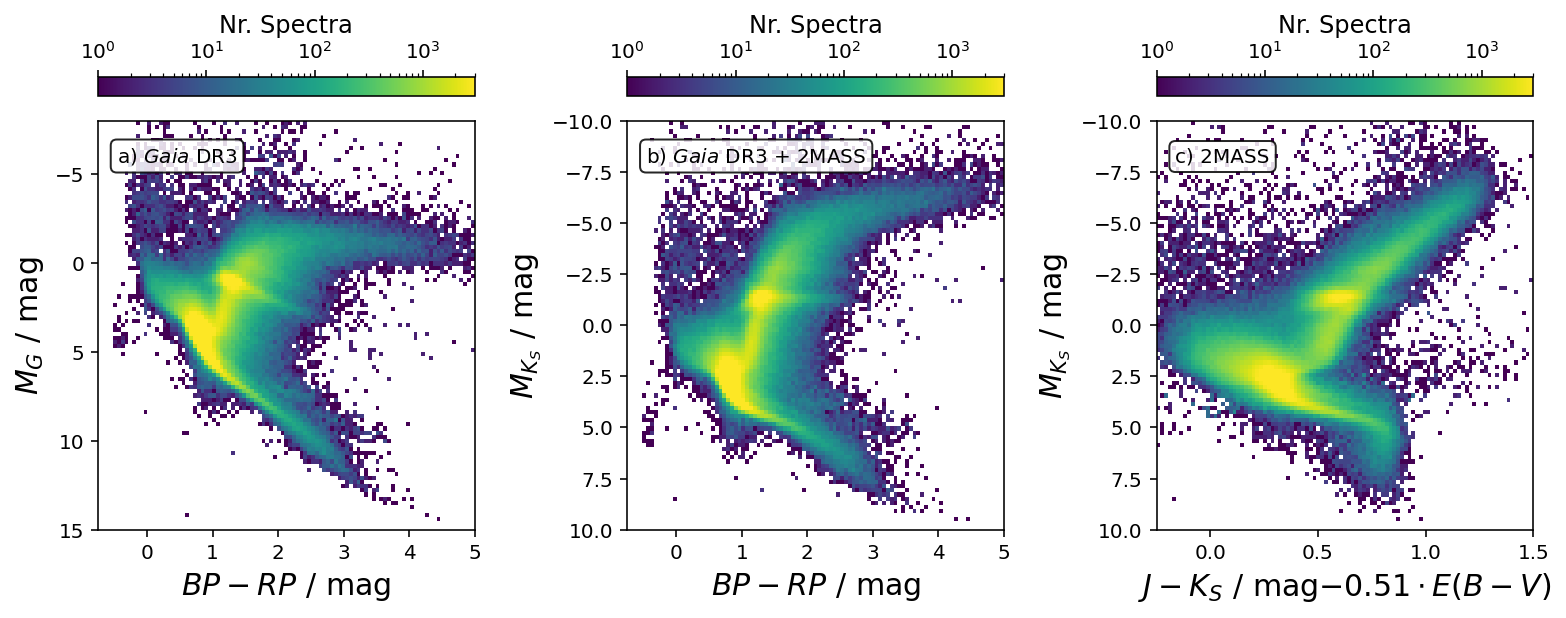

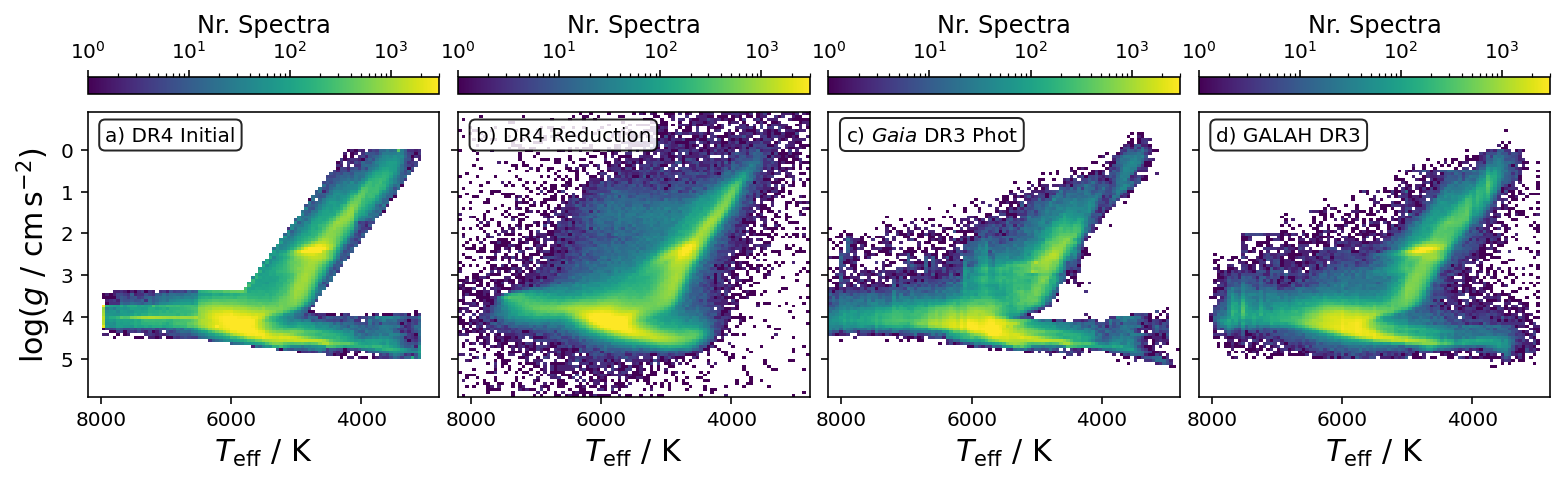

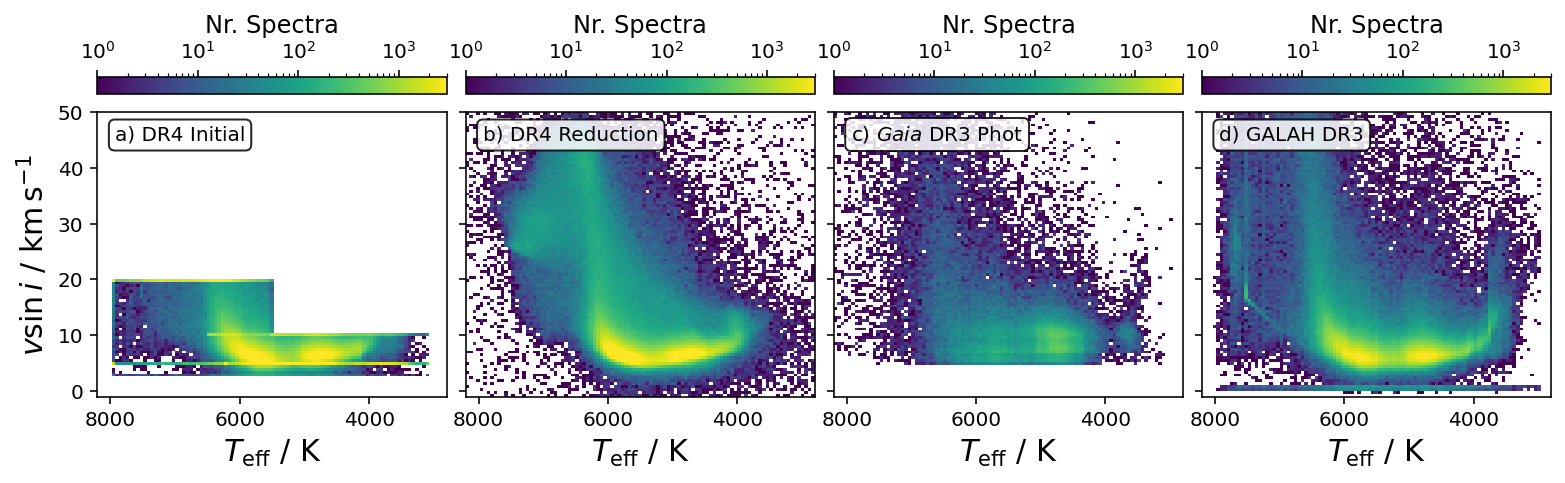

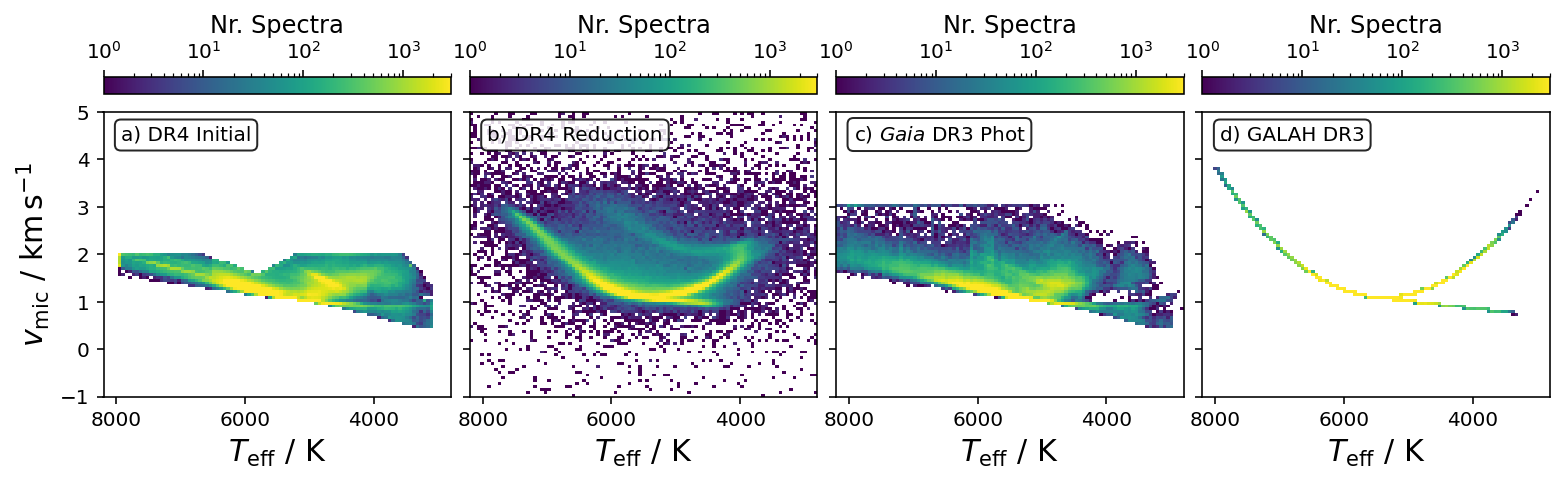

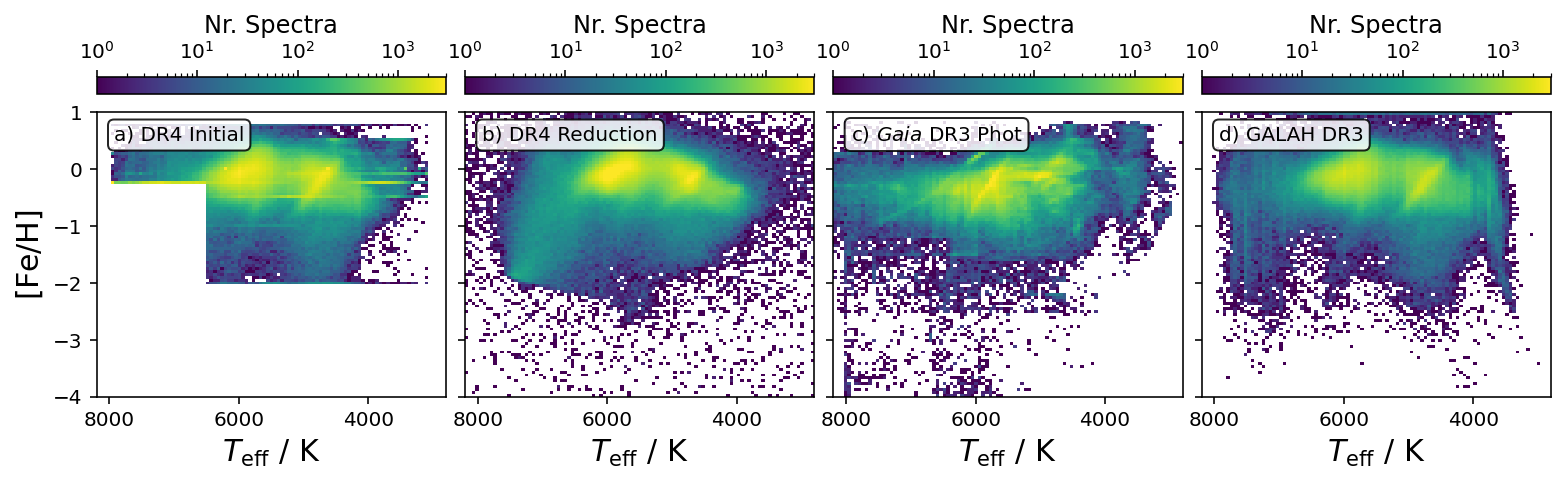

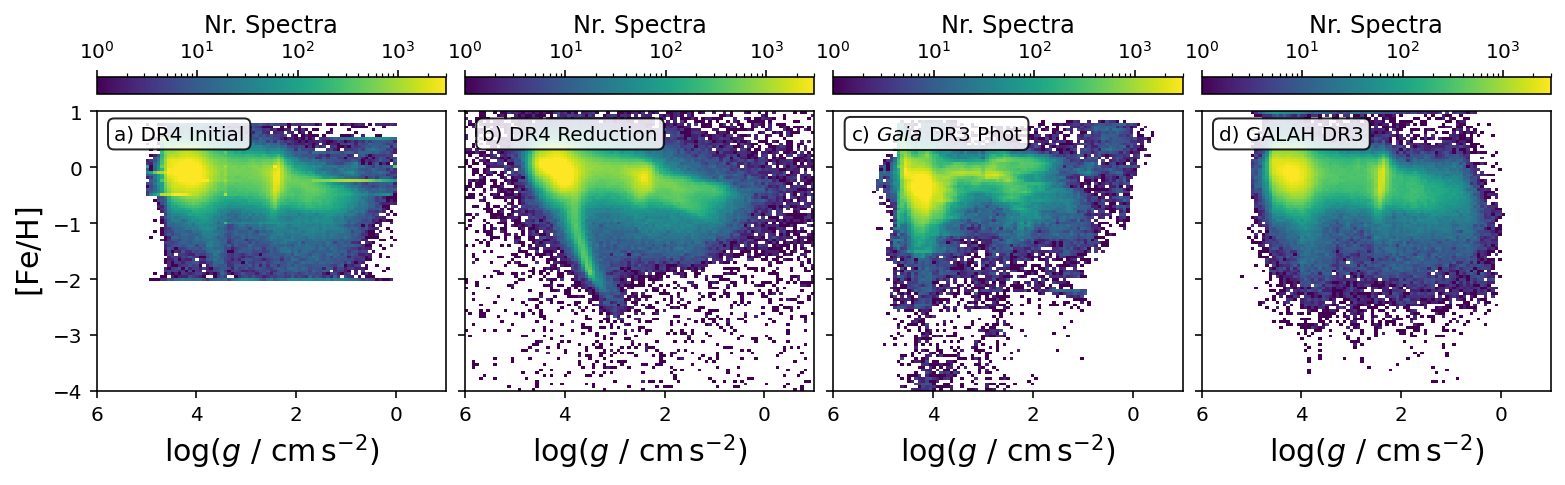

sobject_id,tmass_id,source_id,snr_c1_iraf,snr_c2_iraf,snr_c3_iraf,snr_c4_iraf,sb2_human,sb2_flag,vrad,vrad_source,vrad_red,e_vrad_red,vrad_gaia,e_vrad_gaia,vrad_dr3,e_vrad_dr3,vrad_dr3_guess,flag_sp_dr3,teff,teff_source,teff_red,teff_gaia,e_teff_gaia,teff_dr3,e_teff_dr3,logg,logg_source,logg_red,logg_gaia,e_logg_gaia,logg_dr3,e_logg_dr3,fe_h,fe_h_source,fe_h_red,fe_h_gaia,e_fe_h_gaia,fe_h_dr3,e_fe_h_dr3,vmic,vmic_source,vmic_red,vmic_gaia,vmic_dr3,vsini,vsini_source,vsini_red,vsini_gaia,e_vsini_gaia,vsini_dr3,e_vsini_dr3,bp_rp,parallax,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,j_m,h_m,ks_m,ebv,crval_flag,cdelt_flag,reduction_flags,pivot,plate,res [4]
int64,bytes16,int64,float32,float32,float32,float32,int64,int64,float32,int64,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,int32,int16,int16,float32
131216001101002,05190449-5849304,4762794963745841536,24.843557,36.874645,52.64503,46.820675,-1,-1,6.0732565,0,6.0732565,0.13583478,5.762518,2.2376232,nan,0.065,6.151488,0,4873.9106,1,4855.17,5038.713,10.441406,4873.9106,115.48475,3.0255845,1,2.9531884,3.2853,0.049250007,3.0255845,0.19986692,-0.40244198,1,-0.39622706,-0.2456,0.028349996,-0.40244198,0.091139,1.2288675,1,1.2092074,1.2230445,1.1941862,6.421881,1,6.4077225,nan,nan,6.421881,2.3272226,1.1339941,0.46592104,14.026268,14.514798,13.380804,12.585,12.042,12.001,0.0385,0,0,0,2,0,0.20695877 .. 0.0
131216001101004,05194296-5852488,4762782766038731776,26.910444,39.116535,56.098625,49.812645,-1,-1,54.544594,0,54.544594,0.1737817,58.568233,3.9059474,nan,0.112,54.289078,0,4989.7983,1,5057.936,5466.5923,15.325195,4989.7983,108.27255,3.319194,1,3.2822084,3.6554,0.020599961,3.319194,0.19222258,-0.6668906,1,-0.5430994,-0.1914,0.009599999,-0.6668906,0.09161499,1.1861554,1,1.1383854,1.290928,1.1531022,5.8714843,1,5.958467,nan,nan,5.8714843,2.3690886,1.0558538,0.61384124,13.879523,14.325276,13.269423,12.522,12.048,11.964,0.0376,0,0,0,4,0,0.21255083 .. 0.0
131216001101006,05242175-5855050,4762746688313325568,2.7553246,7.7672753,19.283684,26.94849,-1,-1,20.261442,0,20.261442,0.48034406,22.222137,3.4194565,nan,nan,-1.0,-1,4012.9976,8,5876.0513,nan,nan,nan,nan,4.6815276,8,2.9786448,nan,nan,nan,nan,-0.1,8,0.07007778,nan,nan,nan,nan,0.9221618,8,2.1773663,nan,nan,5.0,8,19.495605,nan,nan,nan,nan,2.1449833,6.563217,14.936241,16.037773,13.89279,12.551,11.961,11.716,0.029,0,4,4096,6,0,0.21175617 .. 0.0
131216001101007,05235853-5855322,4762746963191266560,15.785746,32.32001,54.914253,55.59654,-1,-1,100.09342,0,100.09342,0.13501136,99.8278,2.090019,nan,0.1,98.95314,0,4665.9897,1,4738.3496,4769.1143,80.708496,4665.9897,109.79667,2.3033054,1,2.269136,2.5069,0.13920009,2.3033054,0.22196004,-0.41888714,1,-0.38502097,-0.2799,0.008499995,-0.41888714,0.09651265,1.4340066,1,1.3707609,1.4005289,1.2948282,6.9947014,1,7.659145,nan,nan,6.9947014,2.3303761,1.2855358,0.23927097,13.881007,14.453687,13.168151,12.263,11.617,11.53,0.0266,0,0,0,7,0,0.20908263 .. 0.0
131216001101008,05250796-5856306,4762744661088764928,13.803916,22.49135,35.75572,33.920254,-1,-1,54.401413,0,54.401413,0.28571656,51.142334,3.0113895,nan,0.132,54.1468,0,5230.86,1,5019.4443,5476.285,6.831543,5230.86,130.53845,4.5141425,1,3.9334745,4.5376,0.003250122,4.5141425,0.19311875,-0.57409763,1,-0.32833877,-0.4664,0.008449987,-0.57409763,0.120892815,1.0660658,1,1.1003287,1.1058269,1.0569376,8.049709,1,6.6646852,nan,nan,8.049709,2.619177,0.93122005,2.5778625,13.569149,13.950929,13.019709,12.368,11.947,11.917,0.038,0,4,0,8,0,0.2097261 .. 0.0
131216001101010,05225435-5857055,4762753422822077184,15.966577,33.53854,58.266796,59.57823,-1,-1,13.726945,0,13.726945,0.13316222,12.195503,1.8899336,nan,0.092,13.86

In [73]:
selection = (
    np.isfinite(initial_parameters['fe_h'])
)
print('All',len(initial_parameters['logg'][selection]))
print('Have Gaia',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_gaia'])]))
print('Have DR3',len(initial_parameters['logg'][selection & np.isfinite(initial_parameters['teff_dr3'])]))
print('Have Gaia or DR3',len(initial_parameters['logg'][selection & (np.isfinite(initial_parameters['teff_gaia']) | np.isfinite(initial_parameters['teff_dr3']))]))
print('Have neither Gaia nor DR3',len(initial_parameters['logg'][selection & (np.isnan(initial_parameters['teff_gaia']) & np.isnan(initial_parameters['teff_dr3']))]))
compare_cmd(selection)
compare_teff_logg_red_gaia_dr3(selection)
compare_teff_vsini_red_gaia_dr3(selection)
compare_teff_vmic_red_gaia_dr3(selection)
compare_teff_fe_h_red_gaia_dr3(selection)
compare_logg_fe_h_red_gaia_dr3(selection)
initial_parameters[selection]

In [75]:
np.all([np.isfinite(initial_parameters_lite[param]) for param in ['vrad','teff','logg','fe_h','vmic','vsini']])

True